In [24]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst import utils

In [3]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(right=2.25)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'true_total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

# legend_dict = {
#     'constant': 'Constant-Wait',
#     'linear_runtime': 'Runtime',
#     'linear_cost': 'Cost',
#     'zero': 'No-Wait',
#     'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
# }

legend_dict = {
    ('constant', 1): 'Constant Wait (C=1)',
    ('constant', 2): 'Constant Wait (C=2)',
    ('constant', 4): 'Constant Wait (C=4)',
    ('constant', 8): 'Constant Wait (C=8)',
    ('zero', 1): 'No-Wait',
    
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    df['true_total_cloud_cost'] = df['total_cloud_cost'] * 2.5
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['true_total_cloud_cost_y']
        cost = row['true_total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        cost_mult = 100 * (1 - (cost/baseline_cost))
#         if row['norm_system_utilization'] < 0.75 and cost_mult < 0 :
#             return 5
#         print(row['norm_system_utilization'], row['avg_jct_x'])
        return 100 * (1 - (cost/baseline_cost))
    
    def cost_difference(row):
        baseline_cost = row['true_total_cloud_cost_y']
        cost = row['true_total_cloud_cost_x']
        return baseline_cost - cost
    
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if 'waiting_policy' in groupby_values[0]:
            label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if label == 'No-Wait' and ax_idx<2:
                continue
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    #plt.savefig('figures/motivation/constant_wait.pdf', bbox_inches='tight')
    plt.show()  

In [4]:
constant_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/motivation/constant_ablate.log')

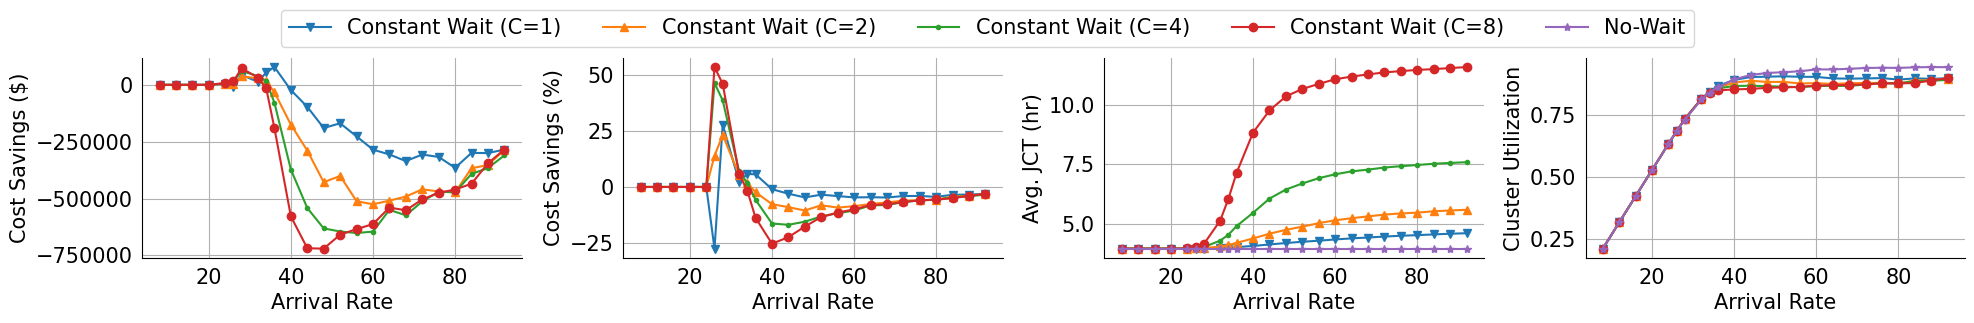

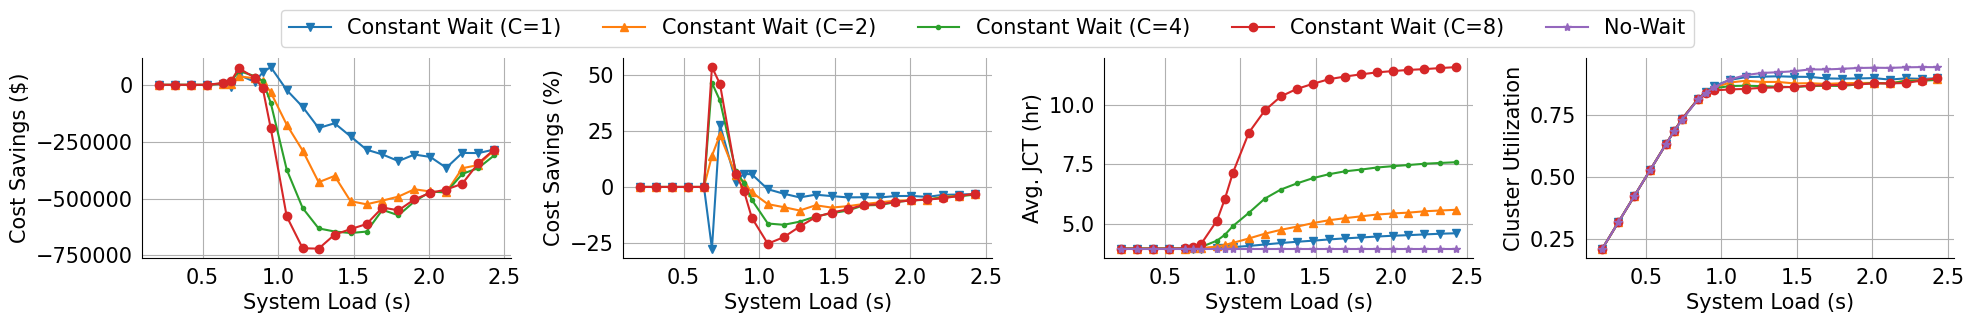

In [69]:
simulator_plotting_fn(constant_df, x_axis='arrival_rate',  \
                      y_axis=['cost_diff','cost_mult','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero',},
                      groupby_values=['waiting_policy', 'waiting_factor', ],
                      normalize_x_axis=False)

simulator_plotting_fn(constant_df, x_axis='arrival_rate',  \
                      y_axis=['cost_diff','cost_mult','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero',},
                      groupby_values=['waiting_policy', 'waiting_factor', ],
                      normalize_x_axis=True)

In [4]:
# For empty space analysis
snapshot_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/motivation/snapshot.log')

In [5]:
def plot_empty_space(jobs, plot=True):
    num_nodes= jobs['cluster_size']
    snapshots = jobs['snapshot'][0]
    jobs = jobs.copy()
    NUM_COLORS = len(jobs['idx'])
    total_jobs = NUM_COLORS
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)]
    fig, ax = plt.subplots(figsize=(100, 50))
    total_gpus = num_nodes * GPUS_PER_NODE

    max_time = np.max(jobs['start'] + jobs['runtime'])
    gpu_id_to_segments = {}
    for j_idx in range(total_jobs):
        allocated_gpus = jobs['allocated_gpus'][j_idx]
        if not allocated_gpus:
            continue
        for node_idx in allocated_gpus.keys():
            for node_gpu_idx in allocated_gpus[node_idx]:
                gpu_idx = total_gpus - (GPUS_PER_NODE * node_idx +
                                        node_gpu_idx)
                if gpu_idx not in gpu_id_to_segments:
                    gpu_id_to_segments[gpu_idx] = []
                
                gpu_id_to_segments[gpu_idx].append((jobs['start'][j_idx], \
                                                    jobs['start'][j_idx] + jobs['runtime'][j_idx]))
    
    for key in gpu_id_to_segments.keys():
        gpu_id_to_segments[key].sort(key=lambda x: x[0])
                
    total_wasted_space = 0.0
    online_wasted_space = 0.0           
    gpu_id_to_antisegments = {}
    time_to_antisegments = {}
    for idx in range(total_gpus):
        if idx not in gpu_id_to_segments:
            if idx not in gpu_id_to_antisegments:
                gpu_id_to_antisegments[idx] = []
            new_seg = (0, max_time)
            if 0 not in time_to_antisegments:
                time_to_antisegments[0] = []
            gpu_id_to_antisegments[idx].append(new_seg)
            time_to_antisegments[0].append((idx-1, max_time))
            continue
        segments = gpu_id_to_segments[idx]
        start_time =0
        cur_segment = (0, 0)
        for seg_idx in range(len(segments)):
            next_segment = segments[seg_idx]
            if idx not in gpu_id_to_antisegments:
                gpu_id_to_antisegments[idx] = []
            if cur_segment[1] == next_segment[0]:
                cur_segment = next_segment
                continue
            antisegment = (cur_segment[1], next_segment[0])
            antisegment_width = antisegment[1]-antisegment[0]
            if antisegment_width <0:
                import pdb; pdb.set_trace()
            gpu_id_to_antisegments[idx].append(antisegment)
            if cur_segment[1] not in time_to_antisegments:
                time_to_antisegments[cur_segment[1]] = []
            time_to_antisegments[cur_segment[1]].append((idx-1, antisegment_width))
            total_wasted_space += antisegment_width
            cur_segment = next_segment
        
        if cur_segment[1] < max_time:
            new_segment = (cur_segment[1], max_time)
            gpu_id_to_antisegments[idx].append(new_segment)
            new_segment_width = max_time - cur_segment[1]
            total_wasted_space += new_segment_width
            if cur_segment[1] not in time_to_antisegments:
                time_to_antisegments[cur_segment[1]] = []
            time_to_antisegments[cur_segment[1]].append((idx-1, new_segment_width))


    asdf = []
    space_wasted = {'No Q': 0, 'HoL': 0, 'Insuff': 0}
    for time in sorted(time_to_antisegments):
        # Give time to reach STEADY state
#         if time < 1000 or time > 2000:
#             continue
        tuples = time_to_antisegments[time]
        queue = snapshots[time]['new_queue']
        num_empty_gpus = len(tuples)
        node_idx = [int(t[0]/8) for t in tuples]
        # Dict that maps node index to list of index in tuples (gpu_idx, width)
        node_free_gpus = {}
        for i, n in enumerate(node_idx):
            if n not in node_free_gpus:
                node_free_gpus[n] = []
            node_free_gpus[n].append(tuples[i])
            
        if len(queue) ==0:
            color = 'tab:blue'
            for gpu_idx, width in tuples:
                end_segment = not (time!=0 and time + width!= max_time)
                if not end_segment:
                    if not (time < 1000 or time > 2000):
                        space_wasted['No Q'] += width
                    if plot:
                        ax.barh(gpu_idx+1,
                            width=width,
                            #edgecolor='black',
                            height=1.0,
                            left=time,
                            align='edge',
                            color='tab:blue')
                else:
                    if plot:
                        ax.barh(gpu_idx+1,
                            width=width,
                            #edgecolor='black',
                            height=1.0,
                            left=time,
                            align='edge',
                            color='black')
        else:
            cannot_fit_jobs = []
            for q_job in queue:
                num_gpus = q_job.num_gpus
                if num_gpus > num_empty_gpus:
                    continue
                if num_gpus > 8:
                    job_gpu_demands = [8]*int(num_gpus/8)
                    if num_gpus%8:
                        job_gpu_demands.append(num_gpus%8)
                else:
                    job_gpu_demands = [num_gpus]
                
                job_gpu_idx =0
                node_idx_lookup = []
                can_fit = False
                for node_idx, tuple_idx_list in node_free_gpus.items():
                    if job_gpu_demands[job_gpu_idx] <=len(tuple_idx_list):
                        job_gpu_idx+=1
                        node_idx_lookup.append(node_idx)

                    if job_gpu_idx == len(job_gpu_demands):
                        can_fit=True
                        break
                
                # Head of the line blocking
                if can_fit:
                    for idx, node_idx in enumerate(node_idx_lookup):
                        color_tuples = node_free_gpus[node_idx][:job_gpu_demands[idx]]
                        for gpu_idx, width in color_tuples:
                            end_segment = not (time!=0 and time + width!= max_time)
                            if not end_segment:
                                if not (time < 1000 or time > 2000):
                                    space_wasted['HoL'] += width
                                color='tab:orange'
                            else:
                                color = 'black'
                            if plot:
                                ax.barh(gpu_idx+1,
                                    width=width,
                                    height=1.0,
                                    left=time,
                                    align='edge',
                                    color=color)
                        node_free_gpus[node_idx] = node_free_gpus[node_idx][job_gpu_demands[idx]:]
                        num_empty_gpus -= job_gpu_demands[idx]
                else:
                    cannot_fit_jobs.append(q_job)
            # Remaining jobs that can't be fit. Either due to fragmentation or not enough GPU(s)
            cannot_fit_jobs = [j.num_gpus for j in cannot_fit_jobs]
            cannot_fit_jobs.sort()
            cumsum = np.cumsum(cannot_fit_jobs)
            cumsum = [x for x in cumsum if x < num_empty_gpus]
            queue_gpus = max(cumsum) if len(cumsum)>0 else 0

            gpu_counter =0
            for tuples_list in node_free_gpus.values():
                for gpu_idx, width in tuples_list:
                    end_segment = not (time!=0 and time + width!= max_time)
                    if not end_segment:
                        if gpu_counter < queue_gpus:
                            reason_key = 'Insuff'
                            color = 'tab:green' 
#                             reason_key = 'Frag'
#                             color = 'blue'
                        else:
                            # Just not enough nodes
                            reason_key = 'Insuff'
                            color = 'tab:green'
                        if not (time < 1000 or time > 2000):
                            space_wasted[reason_key] += width
                    else:
                        color='black'
                    if plot:
                        ax.barh(gpu_idx+1,
                            width=width,
                            height=1.0,
                            left=time,
                            align='edge',
                            color=color)
                    gpu_counter+=1
    if plot:
        for i in range(total_gpus + 1):
            multiplier = math.ceil(num_nodes / 32)
            if (i + 1) % GPUS_PER_NODE == 1:
                plt.axhline(y=i + 1, linewidth=8 / multiplier, color='brown')
            else:
                plt.axhline(y=i + 1,
                            linewidth=1 / multiplier,
                            color='black',
                            linestyle='--')


        plt.ylim(bottom=1, top=total_gpus + 1)
        #plt.xlim(left=0, right=3000)
        plt.xlim(left=1000, right=2100)
    #     plt.axvline(x=max_time, color='black', linewidth=5)
        plt.tight_layout()
        plt.show()
    total_space_wasted = 0
    for k,v in space_wasted.items():
        total_space_wasted += v
        print(f'{k}: {v}')
    patches, texts = plt.pie(list(space_wasted.values()))
    plt.legend(patches, list(space_wasted.keys()))
    plt.show()
    cloud_cost = 0
    for j_idx in range(total_jobs):
        if jobs['arrival'][j_idx] >= 1000 and jobs['arrival'][j_idx] <=2000:
            if jobs['state'][j_idx]!='LOCAL':
                cloud_cost += jobs['num_gpus'][j_idx] * jobs['runtime'][j_idx]
    space_wasted['cloud_cost'] = cloud_cost
#     patches, texts = plt.pie(list(space_wasted.values())[1:])
#     plt.legend(patches, list(space_wasted.keys())[1:])
#     plt.show()
    print(f'Total Cloud Cost: {cloud_cost}')
    print(f'Total Wasted Space: {total_space_wasted}')
    return space_wasted


No Q: 97302.28887981187
HoL: 0
Insuff: 0


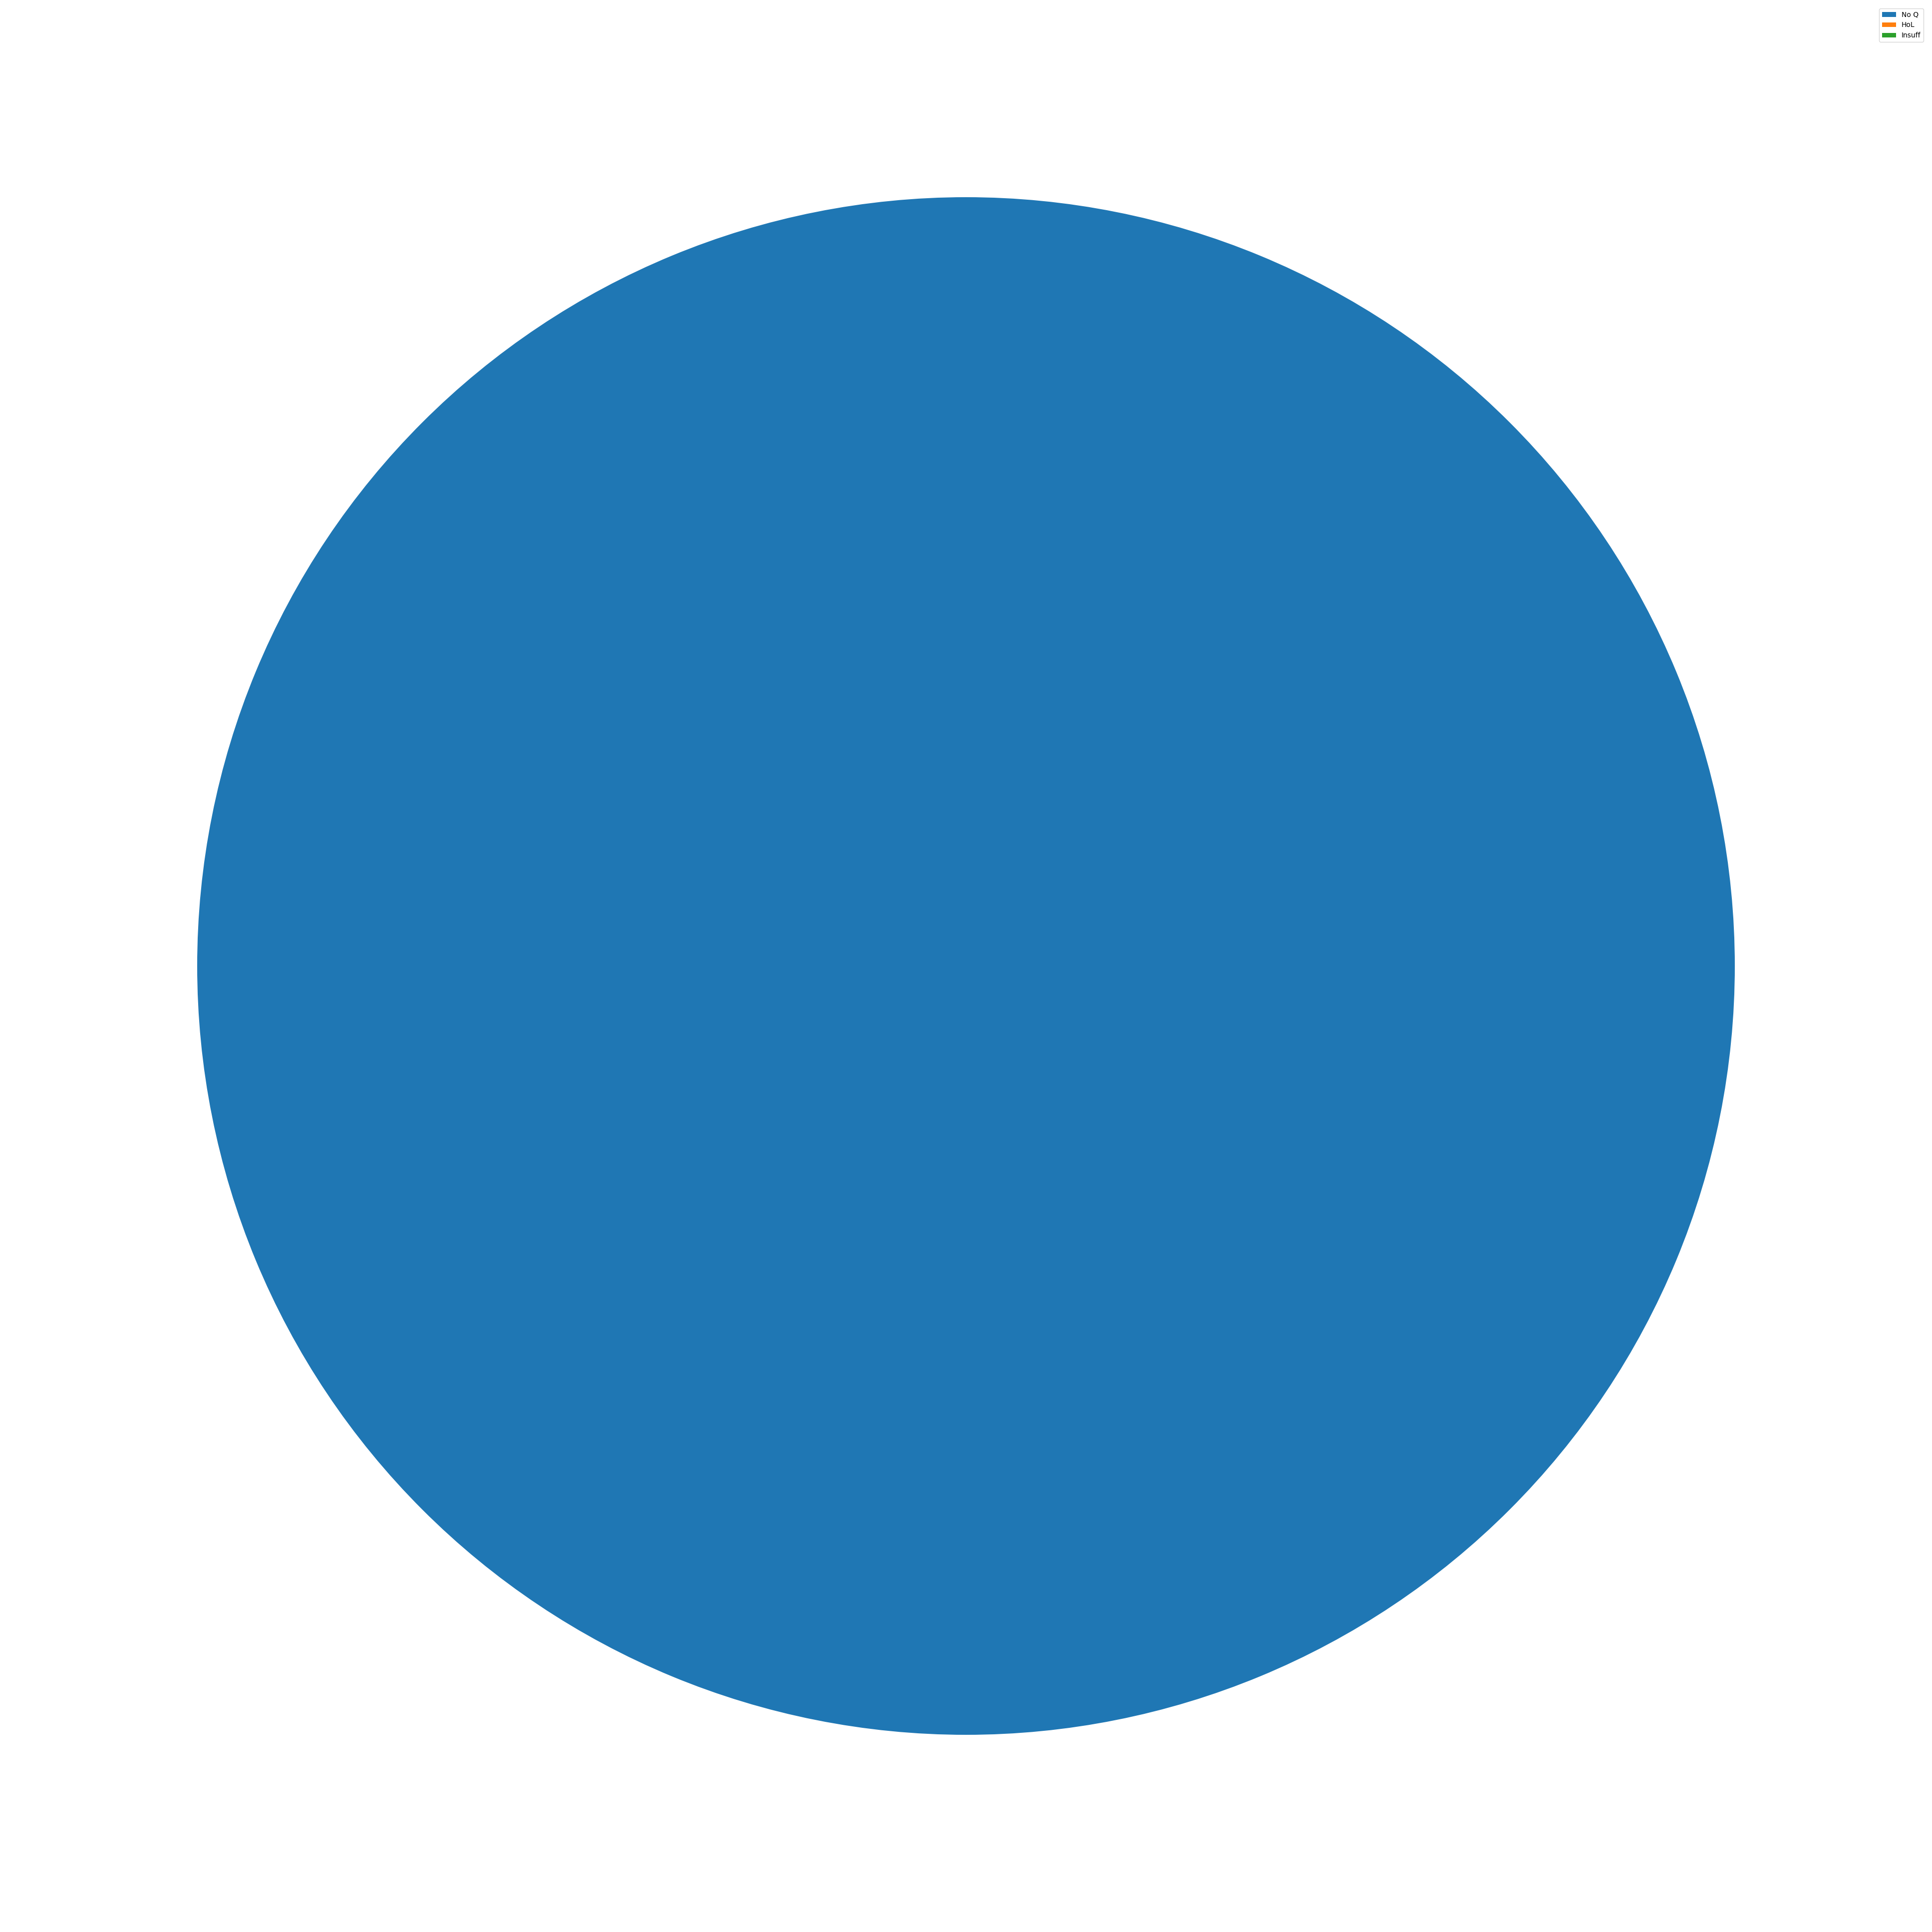

Total Cloud Cost: 9807.191111111111
Total Wasted Space: 97302.28887981187
No Q: 95778.52333776873
HoL: 437.5553793424549
Insuff: 14.694919670816034


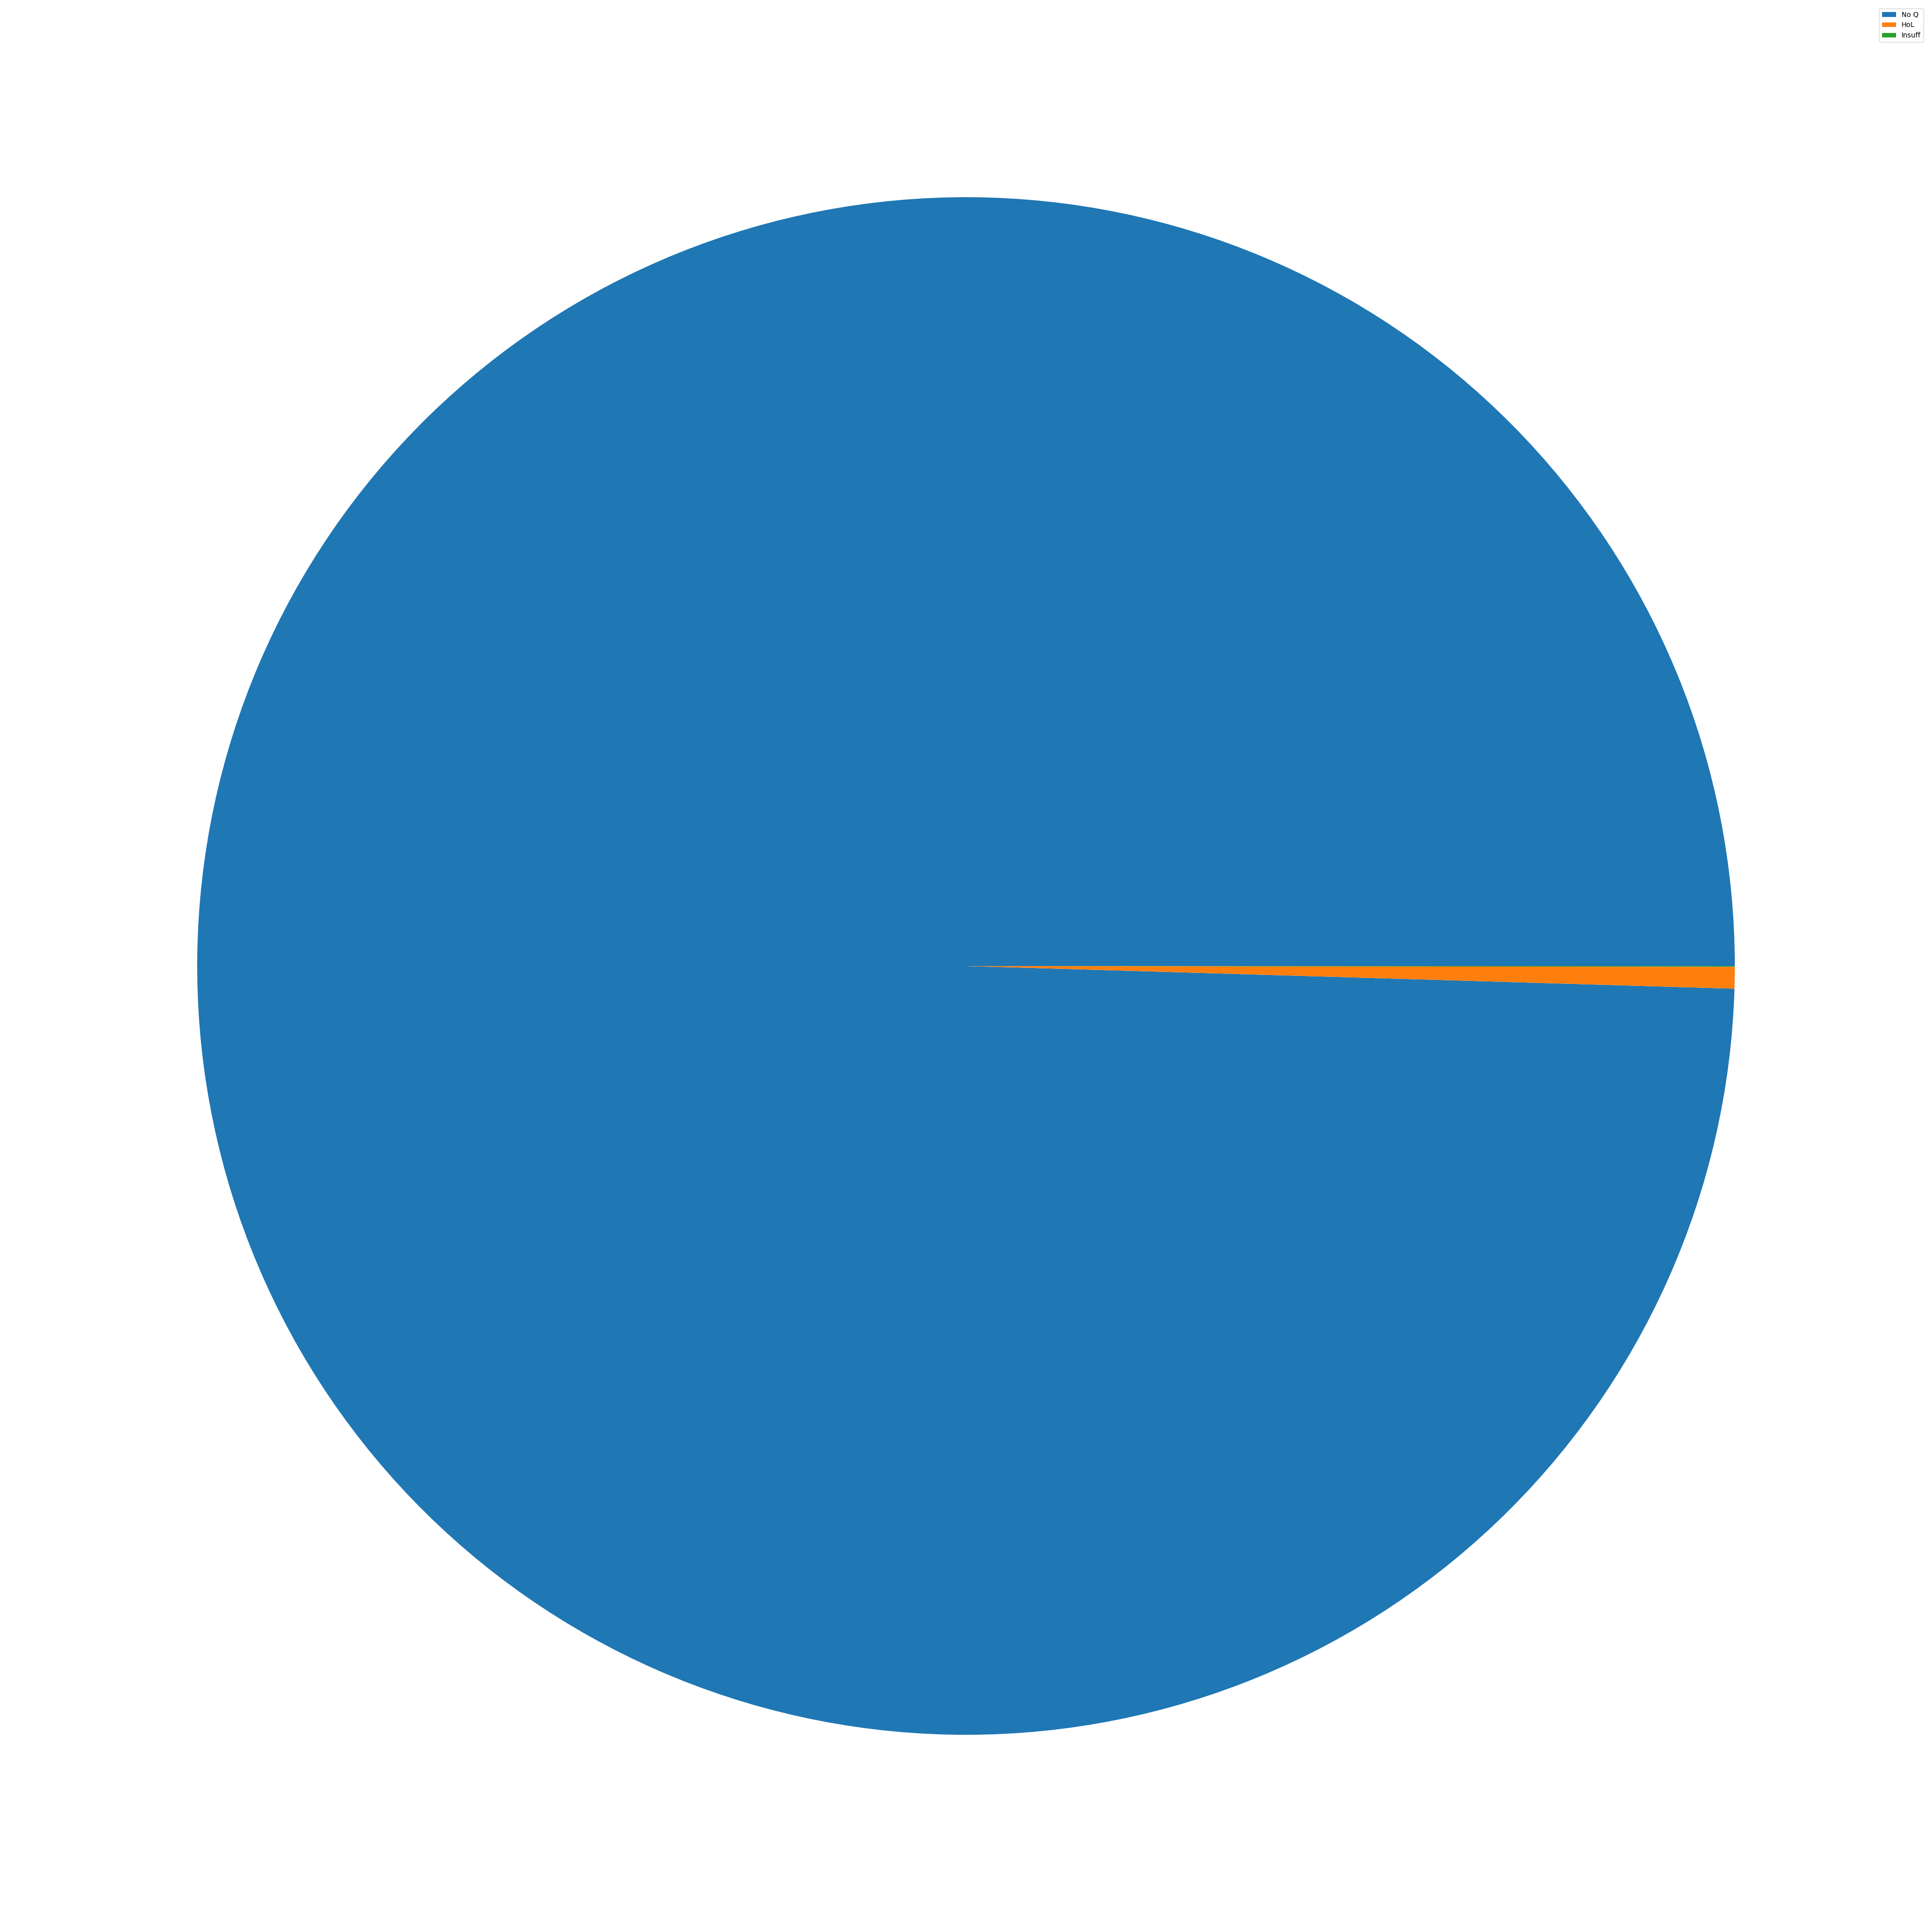

Total Cloud Cost: 9211.662777777781
Total Wasted Space: 96230.77363678199
No Q: 92447.86289067591
HoL: 884.7368776948501
Insuff: 86.98909987400702


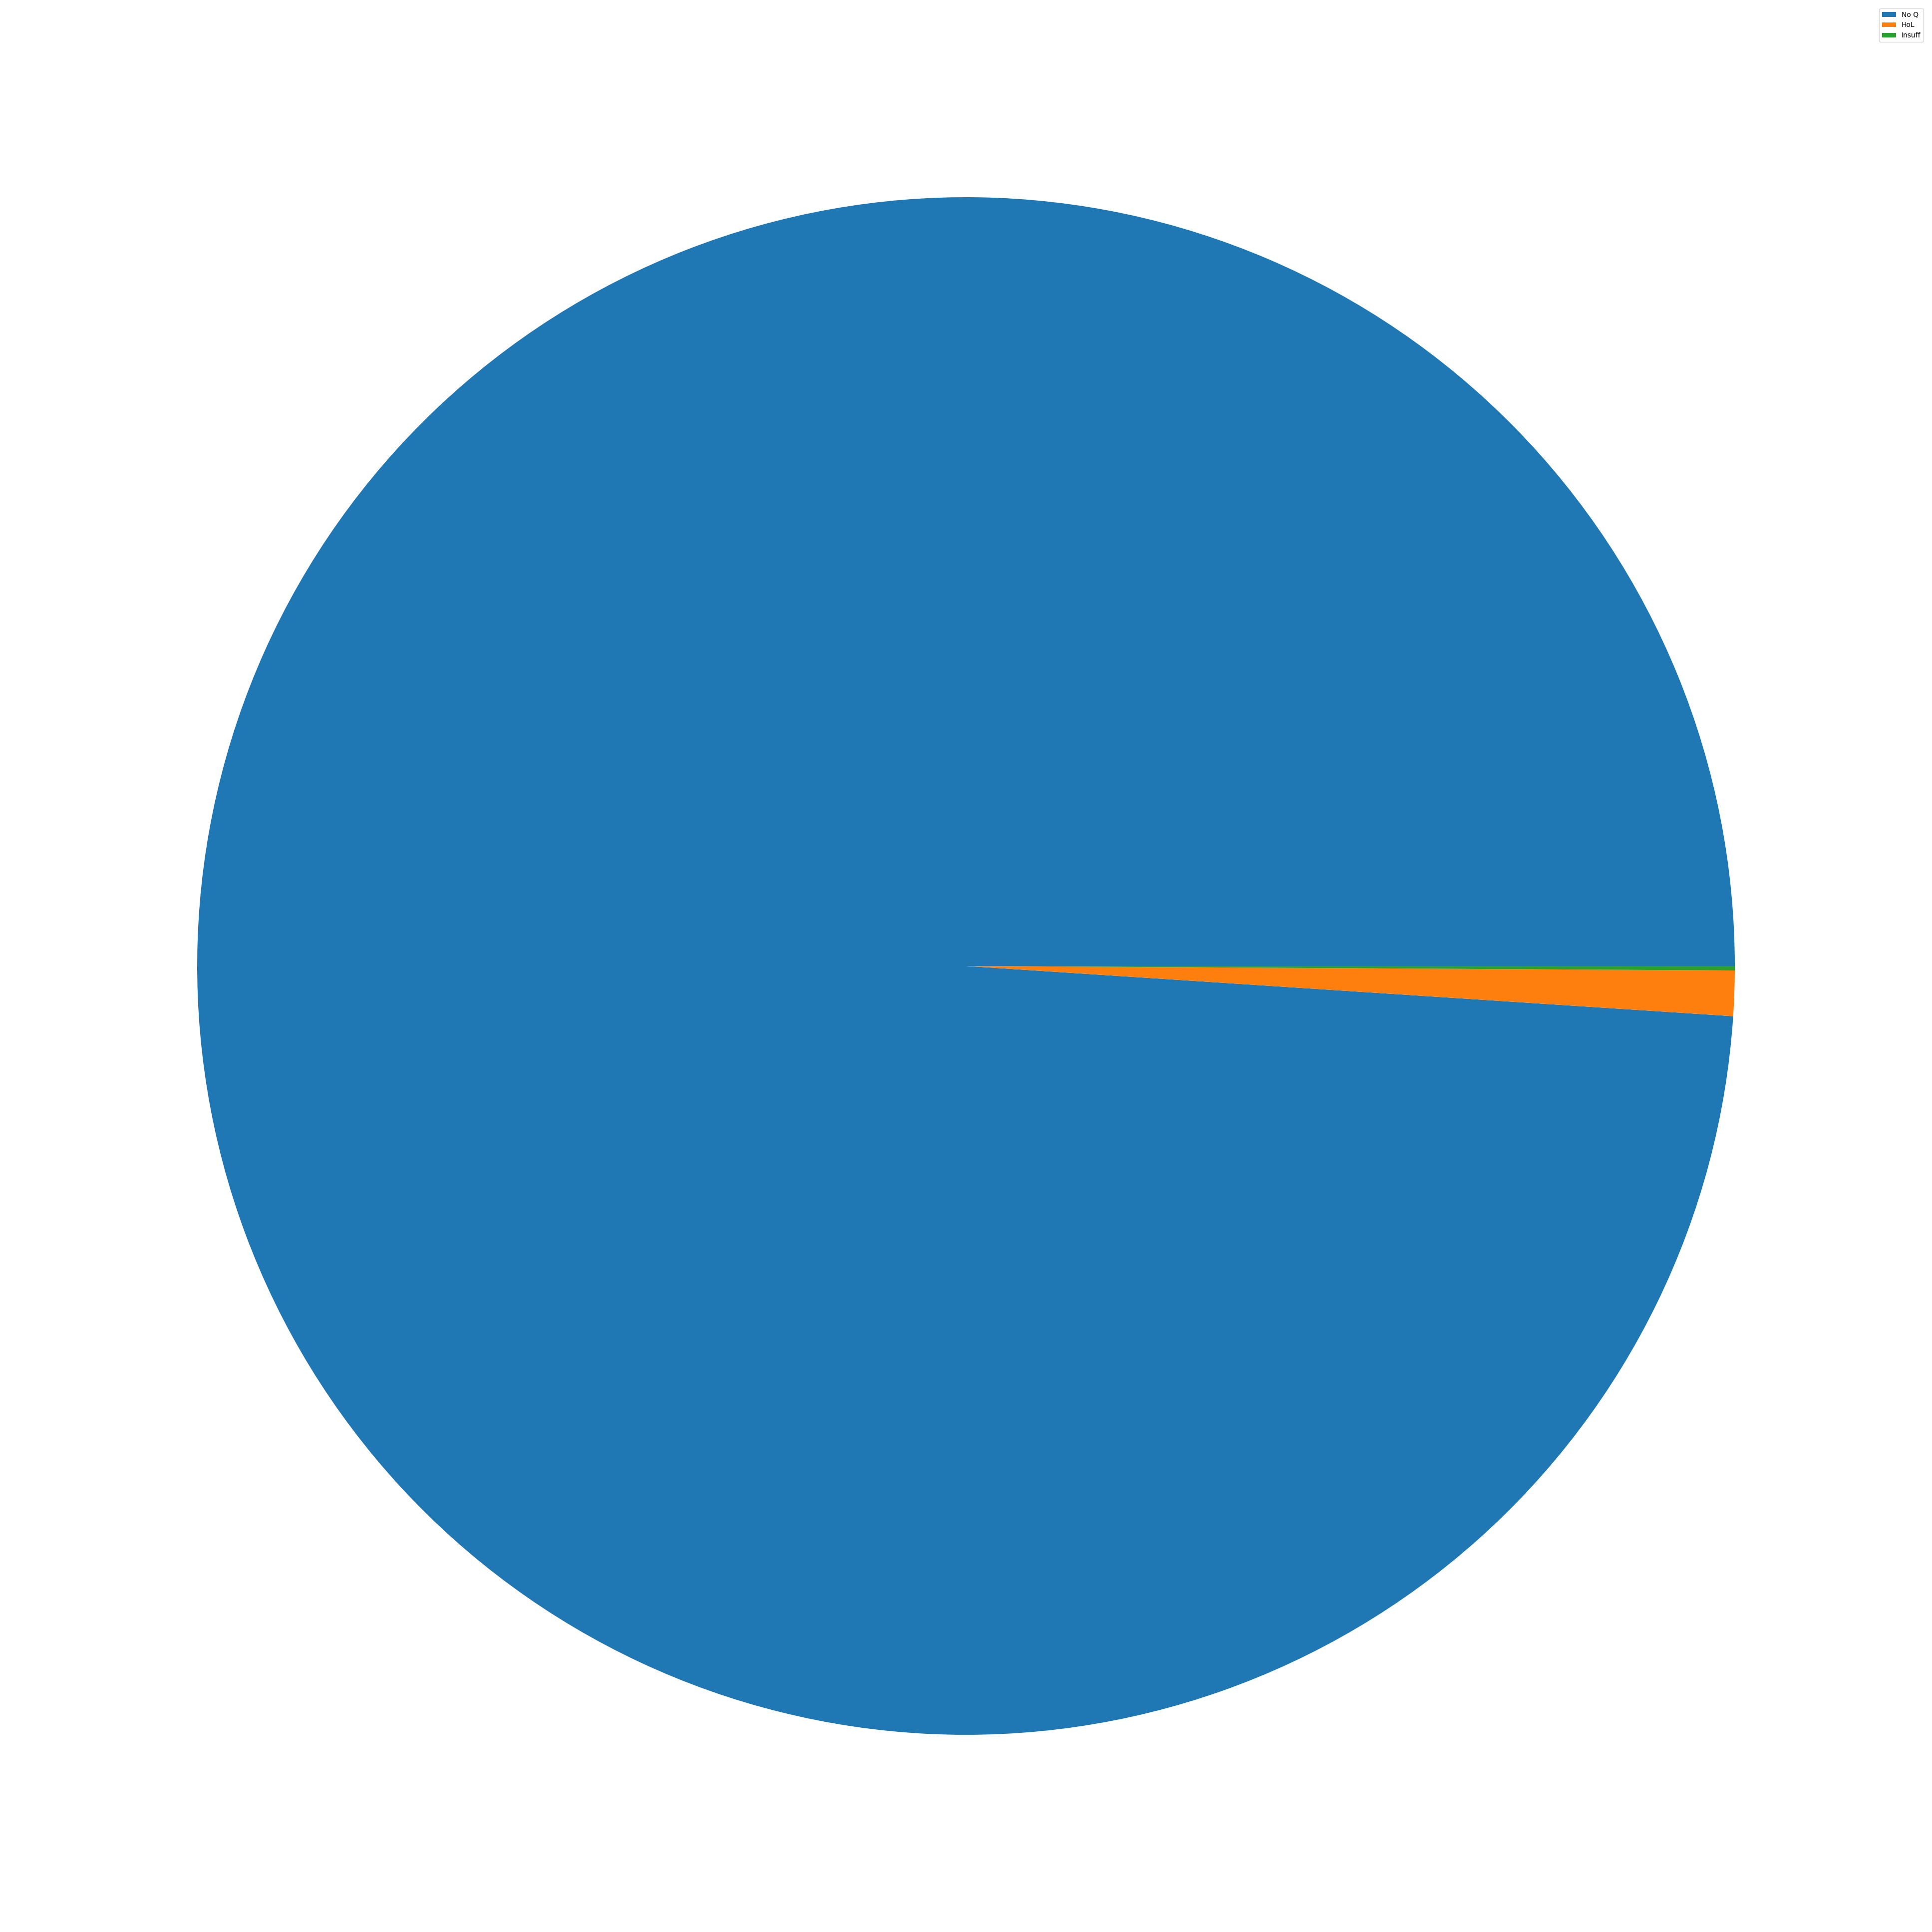

Total Cloud Cost: 6186.51
Total Wasted Space: 93419.58886824477
No Q: 89200.86983799074
HoL: 4240.600684078361
Insuff: 142.809663251433


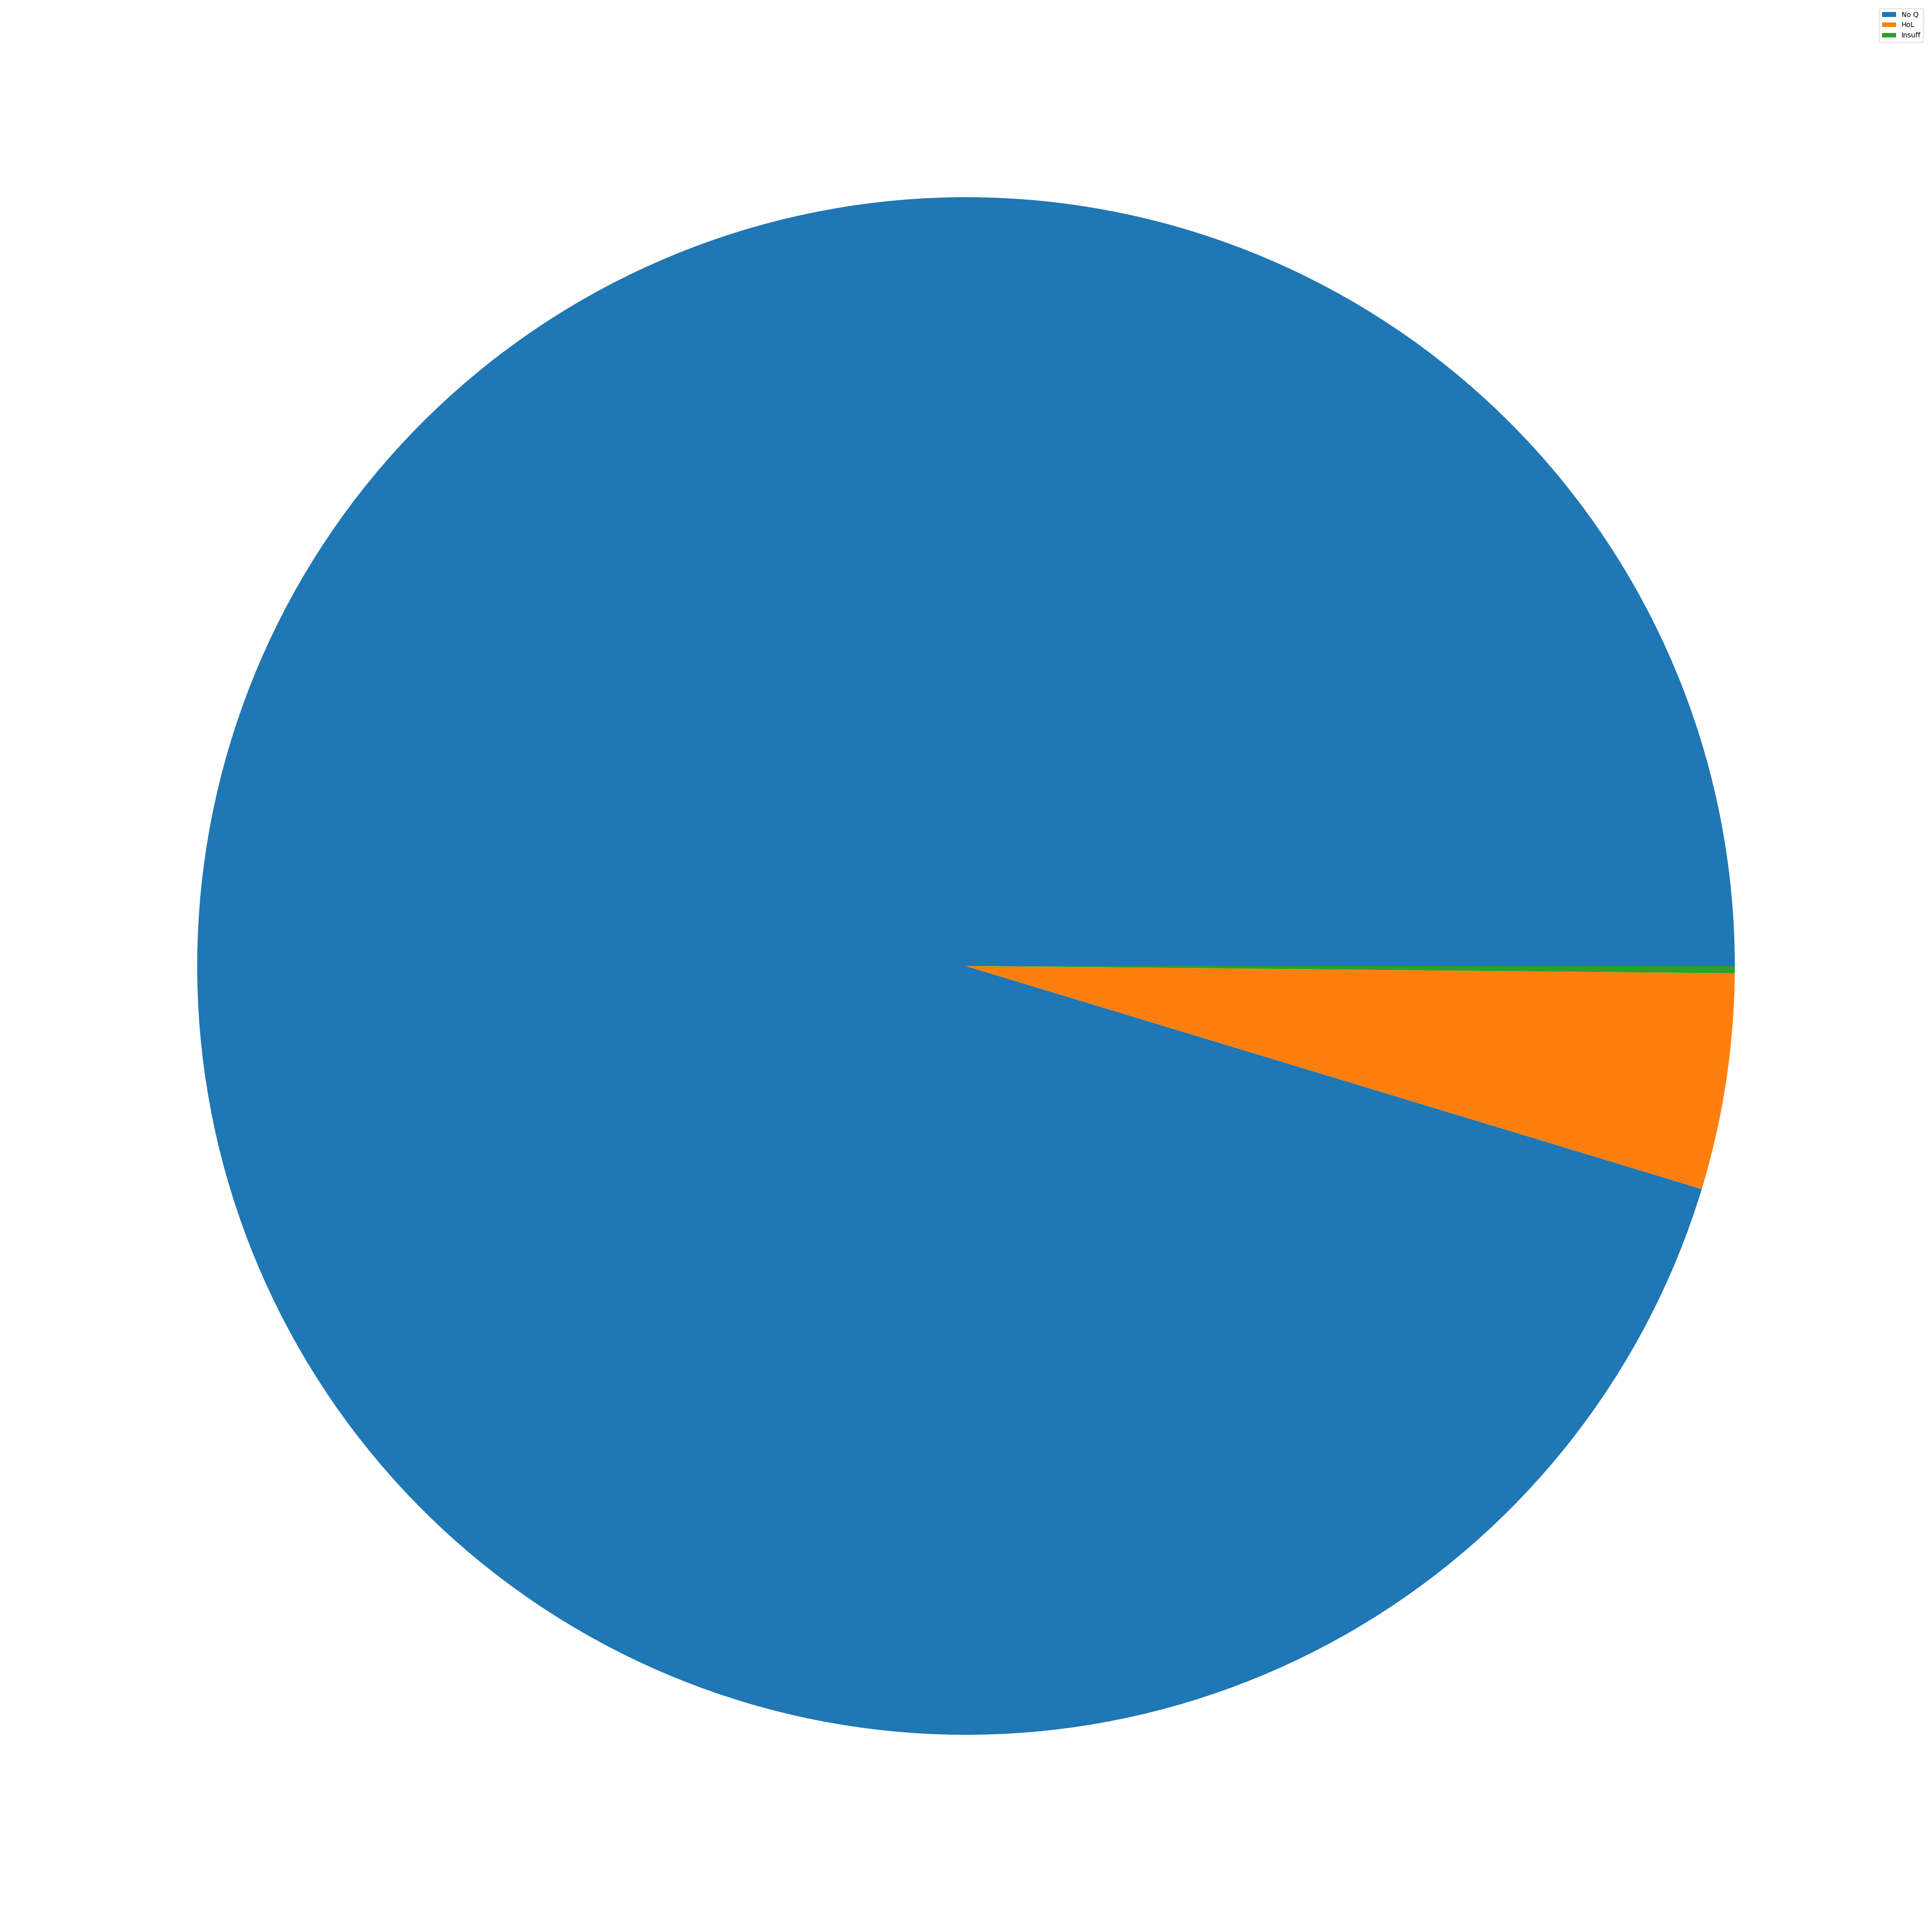

Total Cloud Cost: 6169.588055555557
Total Wasted Space: 93584.28018532055
No Q: 78593.46151883501
HoL: 0
Insuff: 0


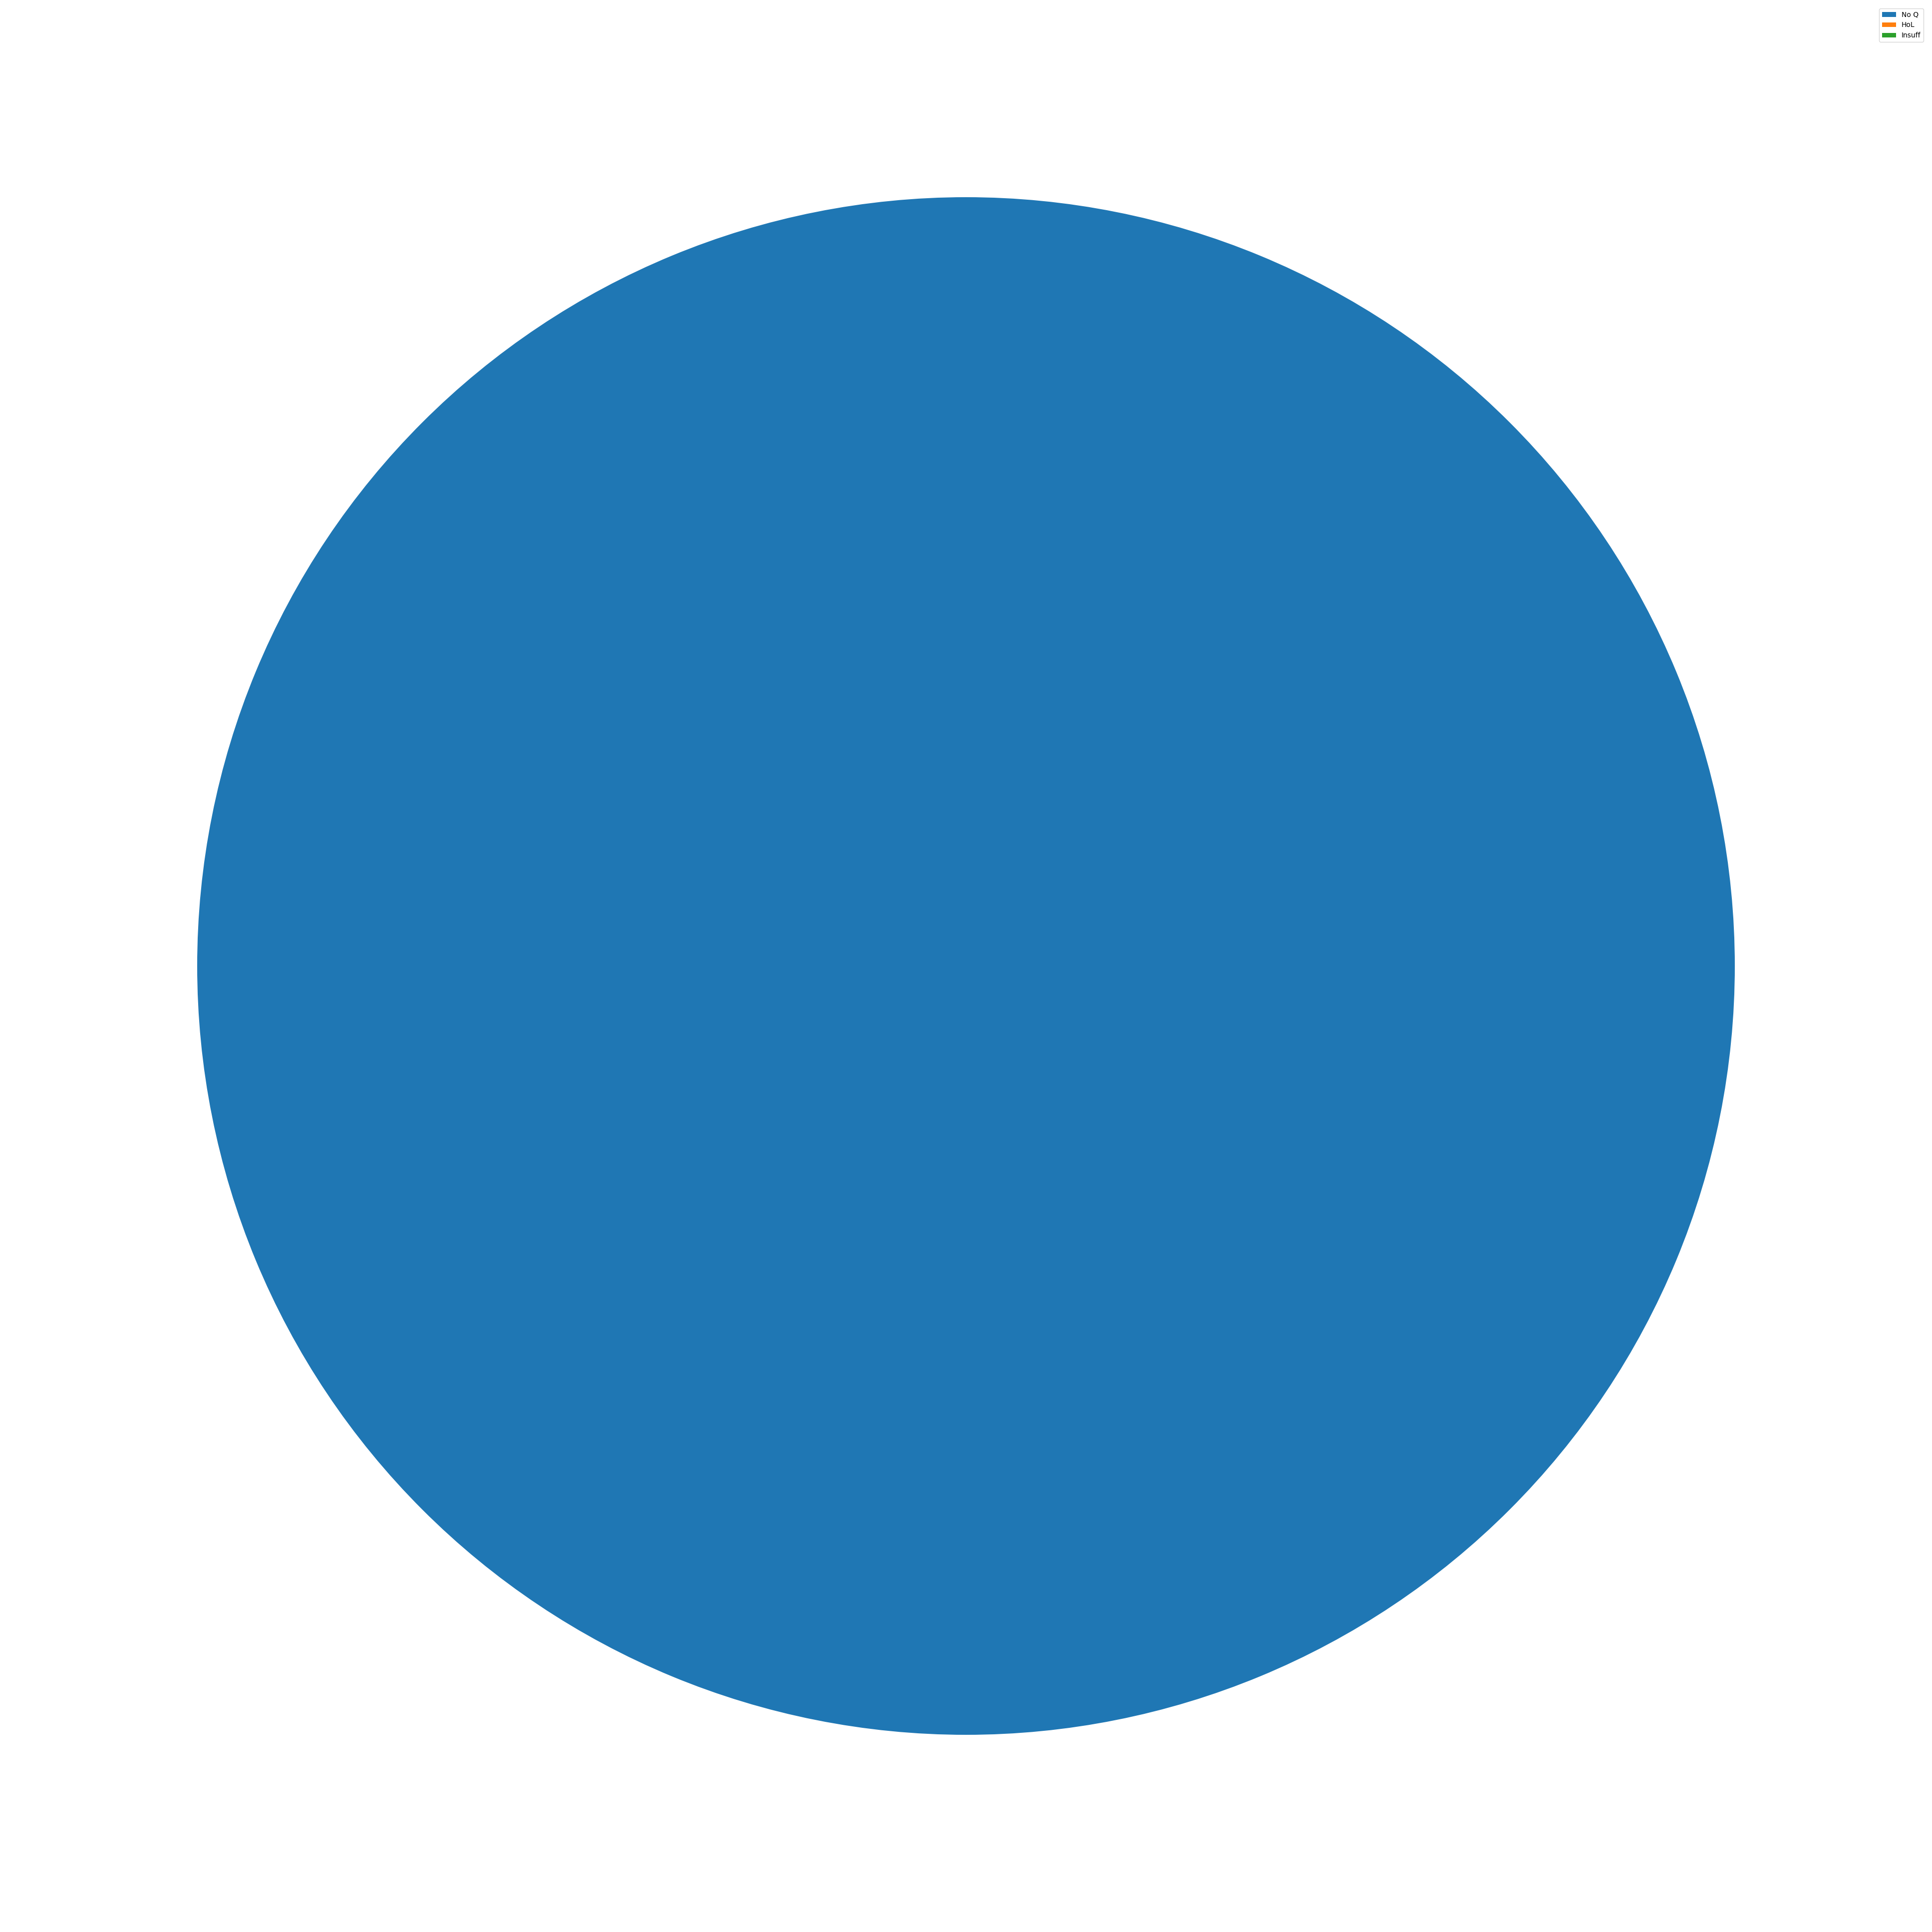

Total Cloud Cost: 27035.57861111112
Total Wasted Space: 78593.46151883501
No Q: 76238.52303799486
HoL: 689.0241156664588
Insuff: 100.72068887714784


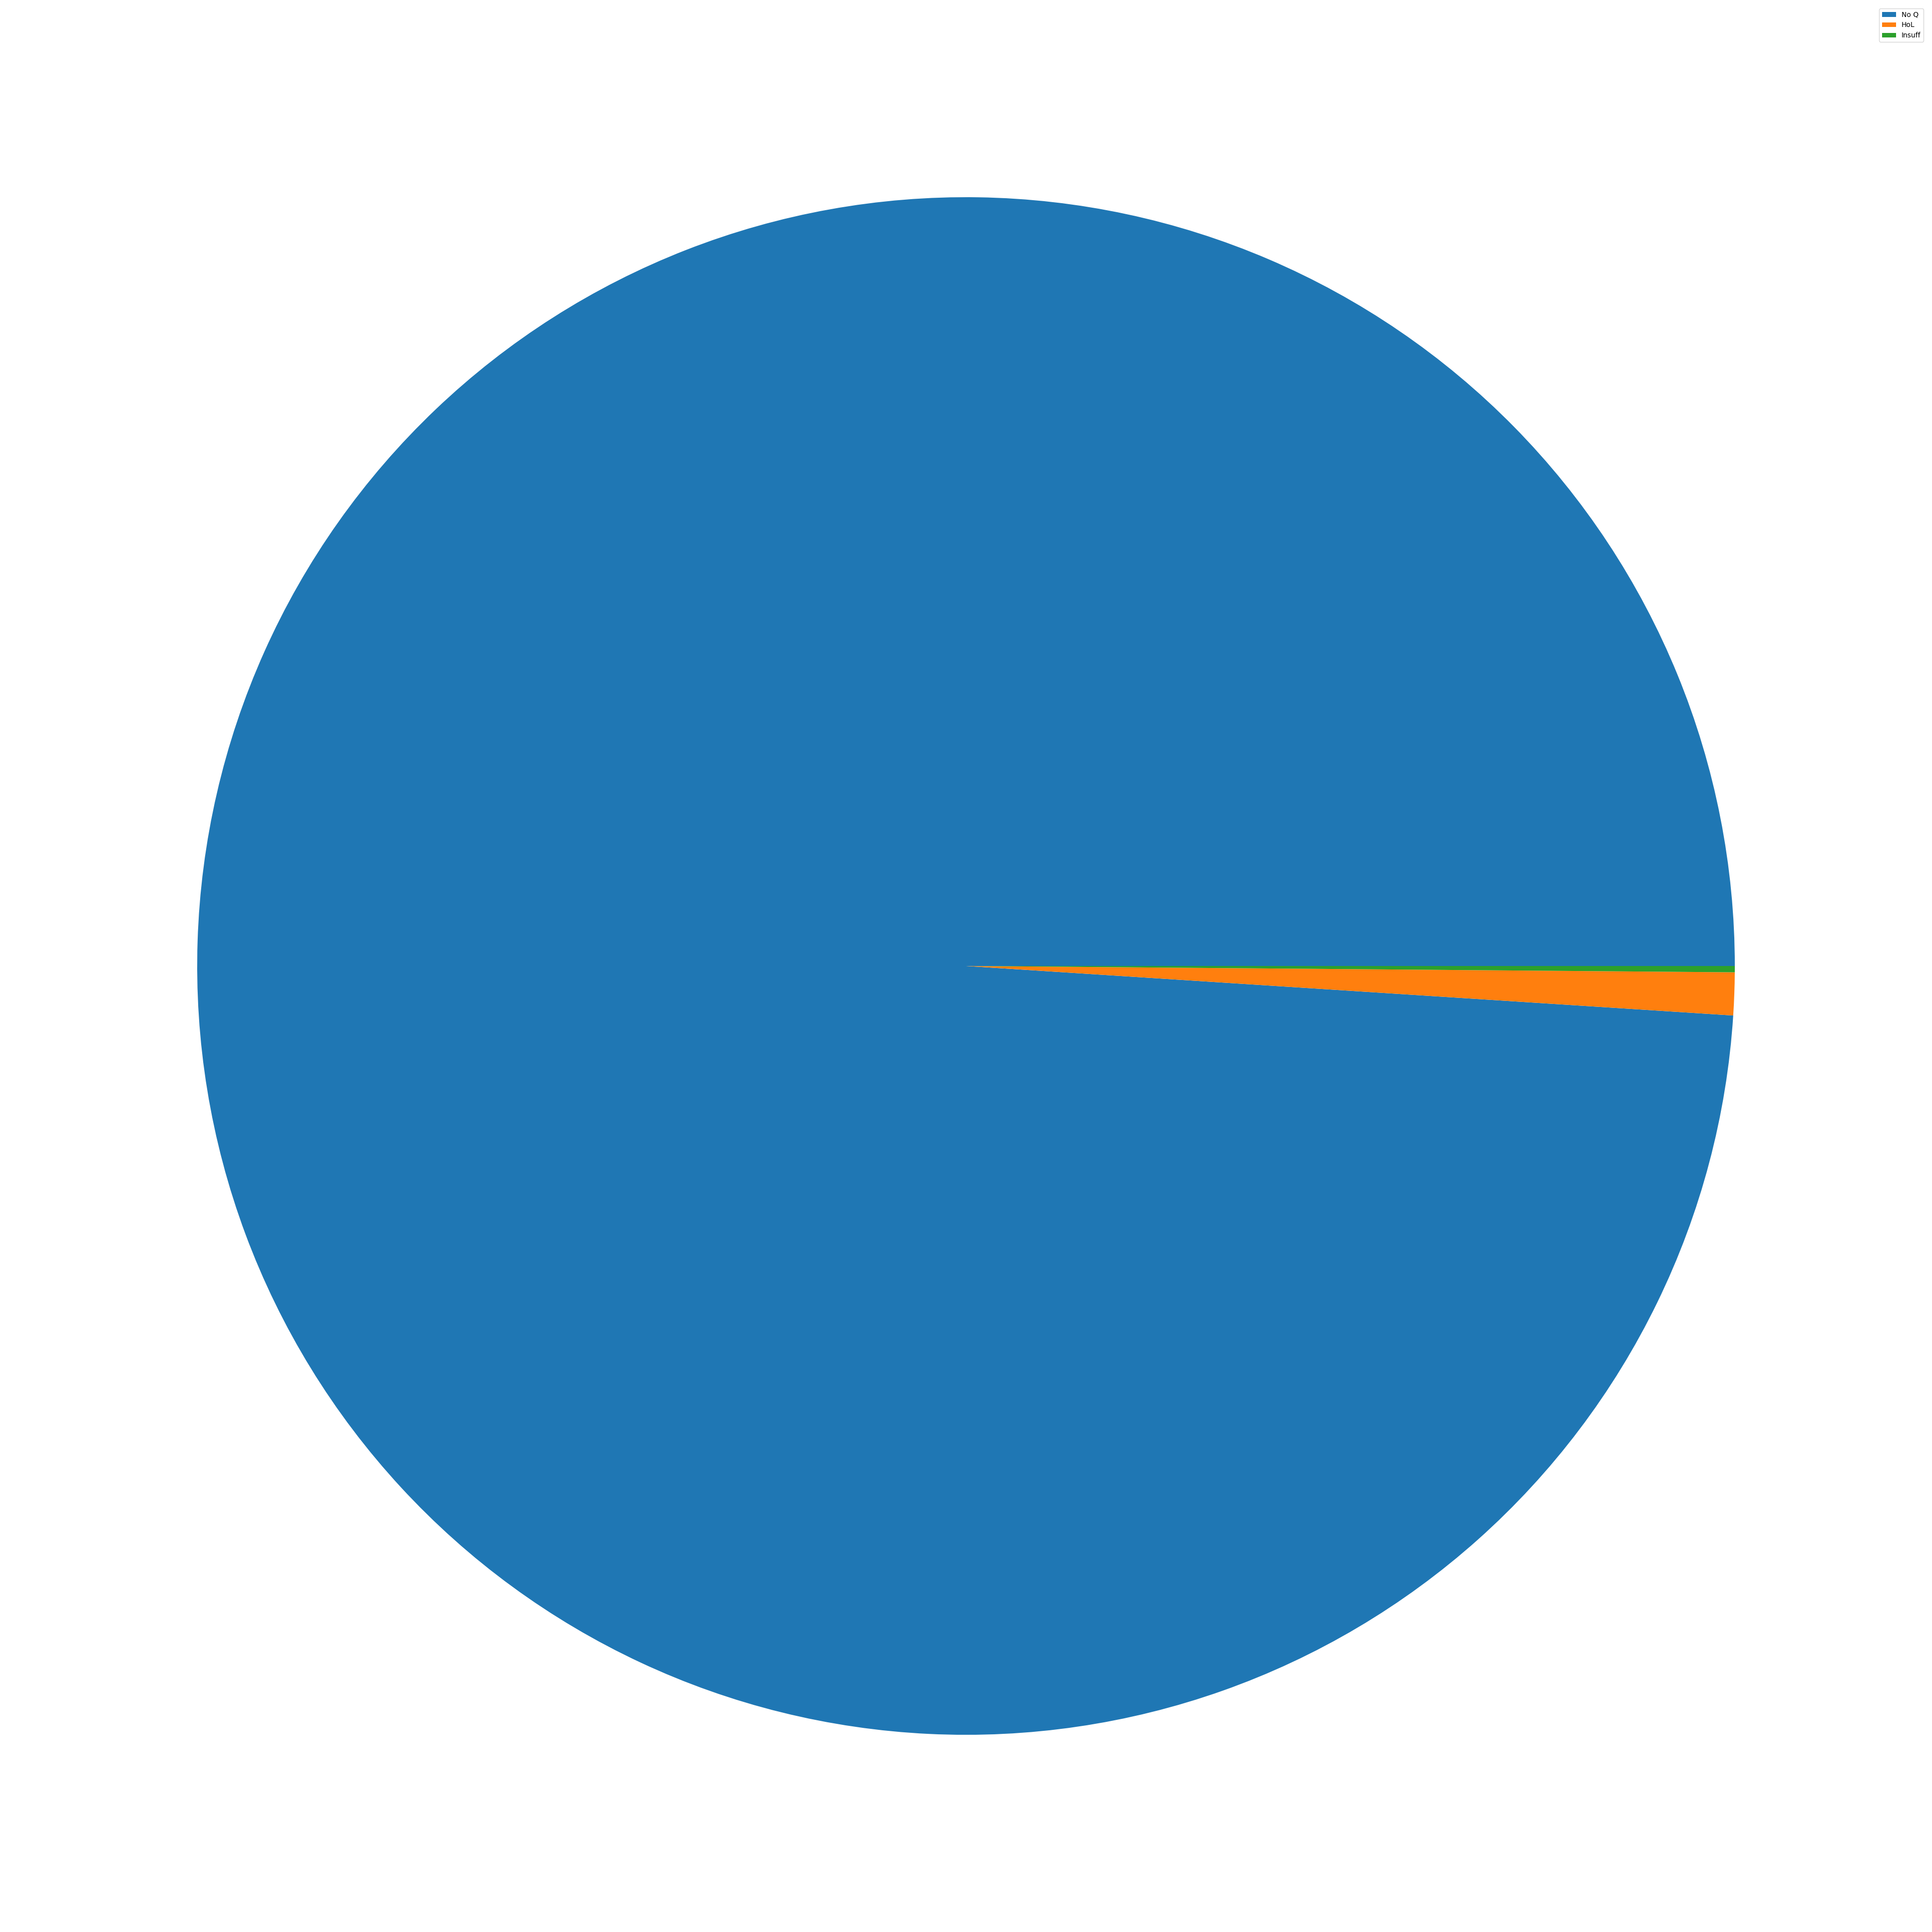

Total Cloud Cost: 26093.775555555567
Total Wasted Space: 77028.26784253847
No Q: 73741.00151162673
HoL: 2419.9496550632957
Insuff: 223.92193401908912


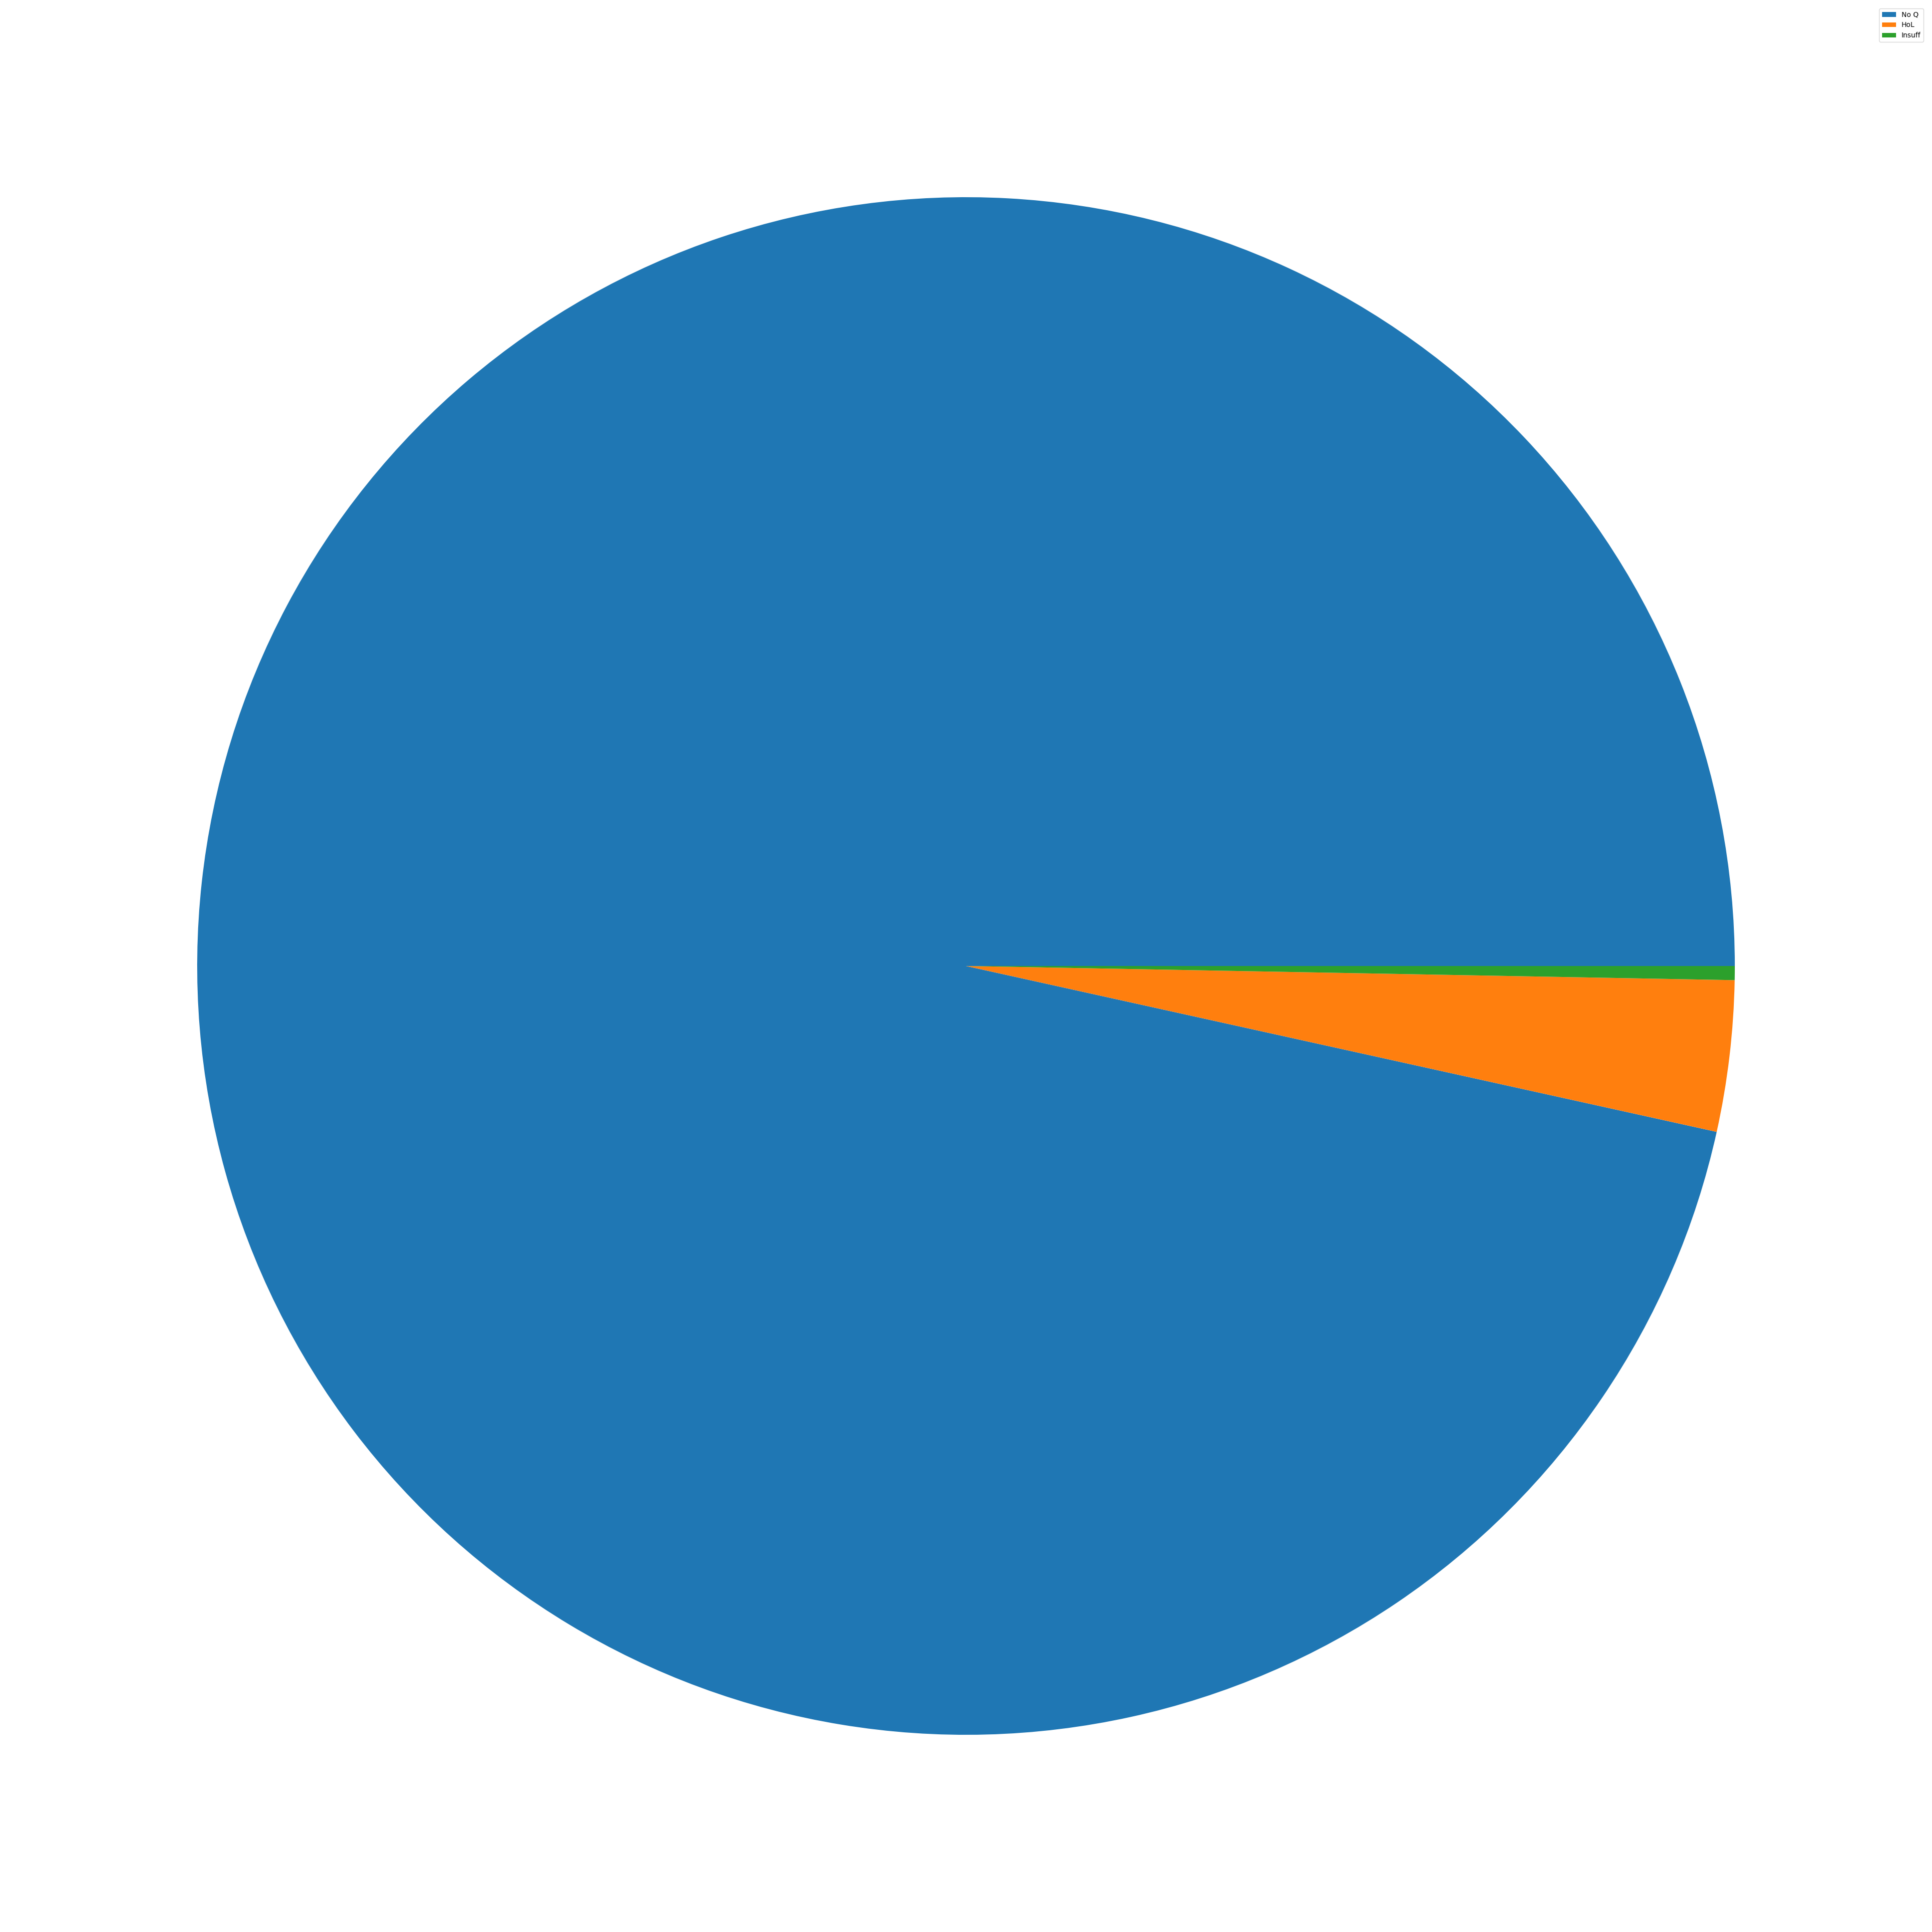

Total Cloud Cost: 18181.541111111113
Total Wasted Space: 76384.87310070911
No Q: 66063.0132625719
HoL: 7272.272636444114
Insuff: 525.8624276077059


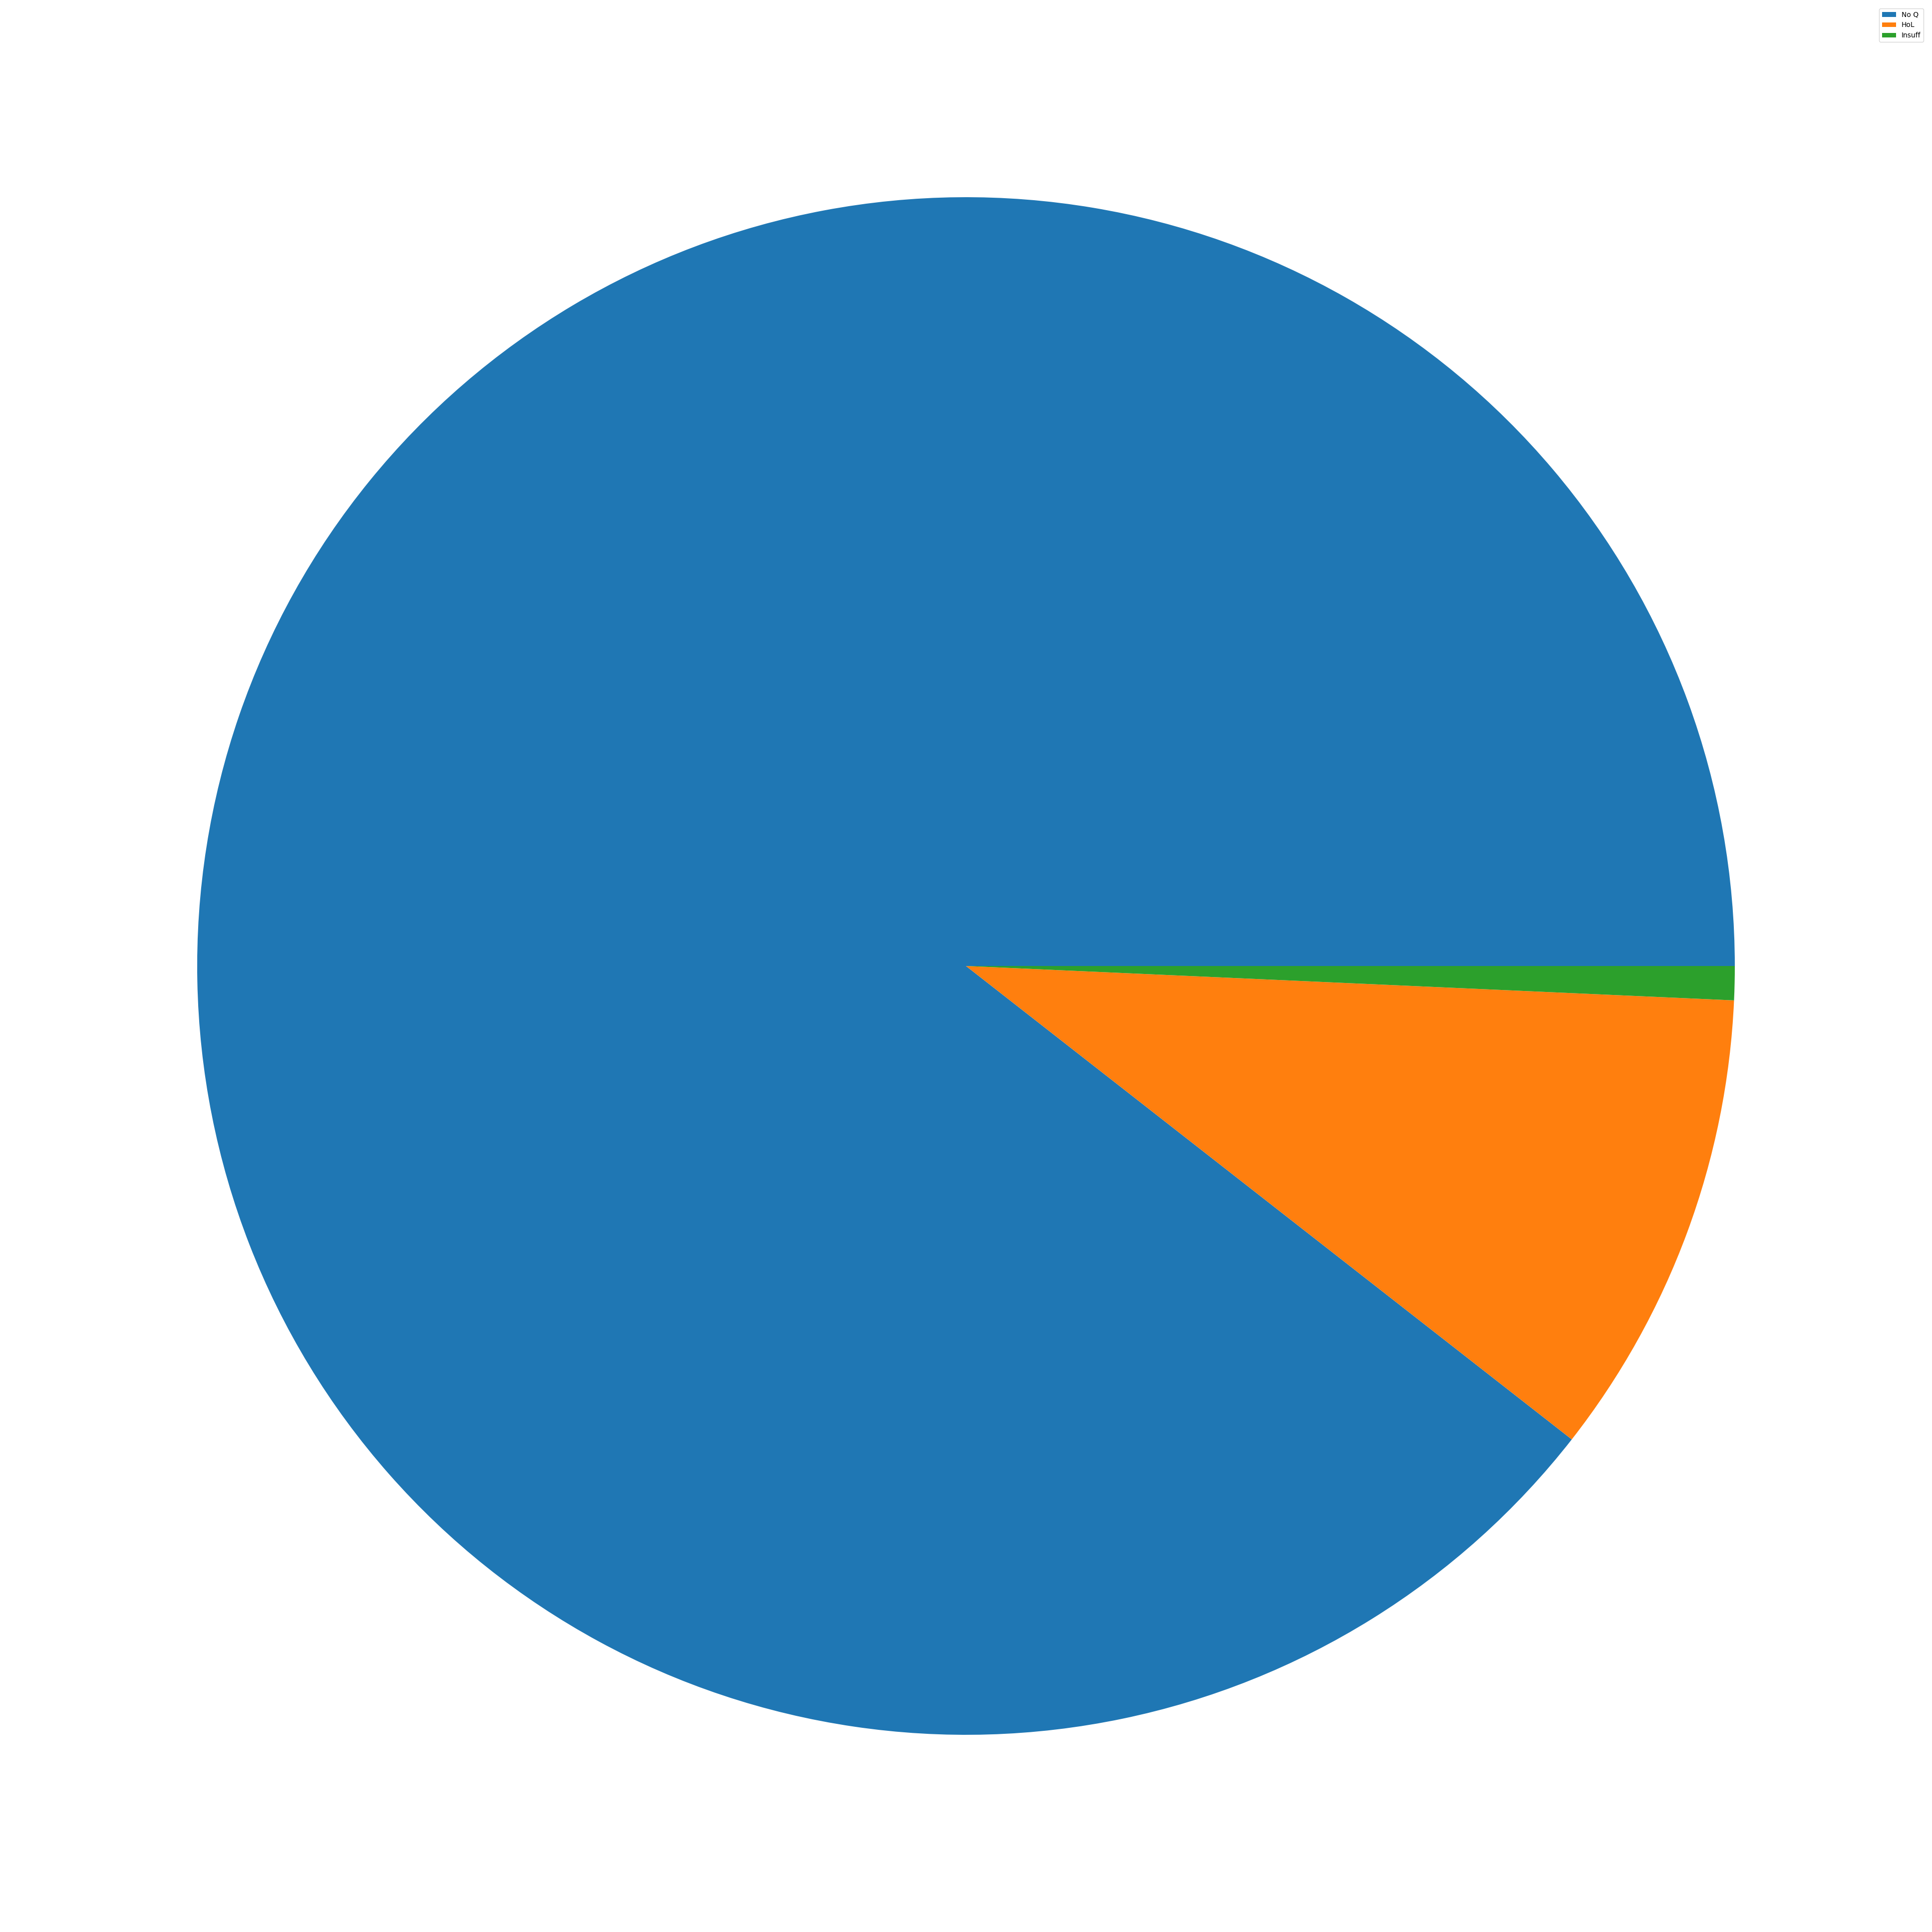

Total Cloud Cost: 16722.303611111114
Total Wasted Space: 73861.14832662372
No Q: 36150.084484990286
HoL: 0
Insuff: 0


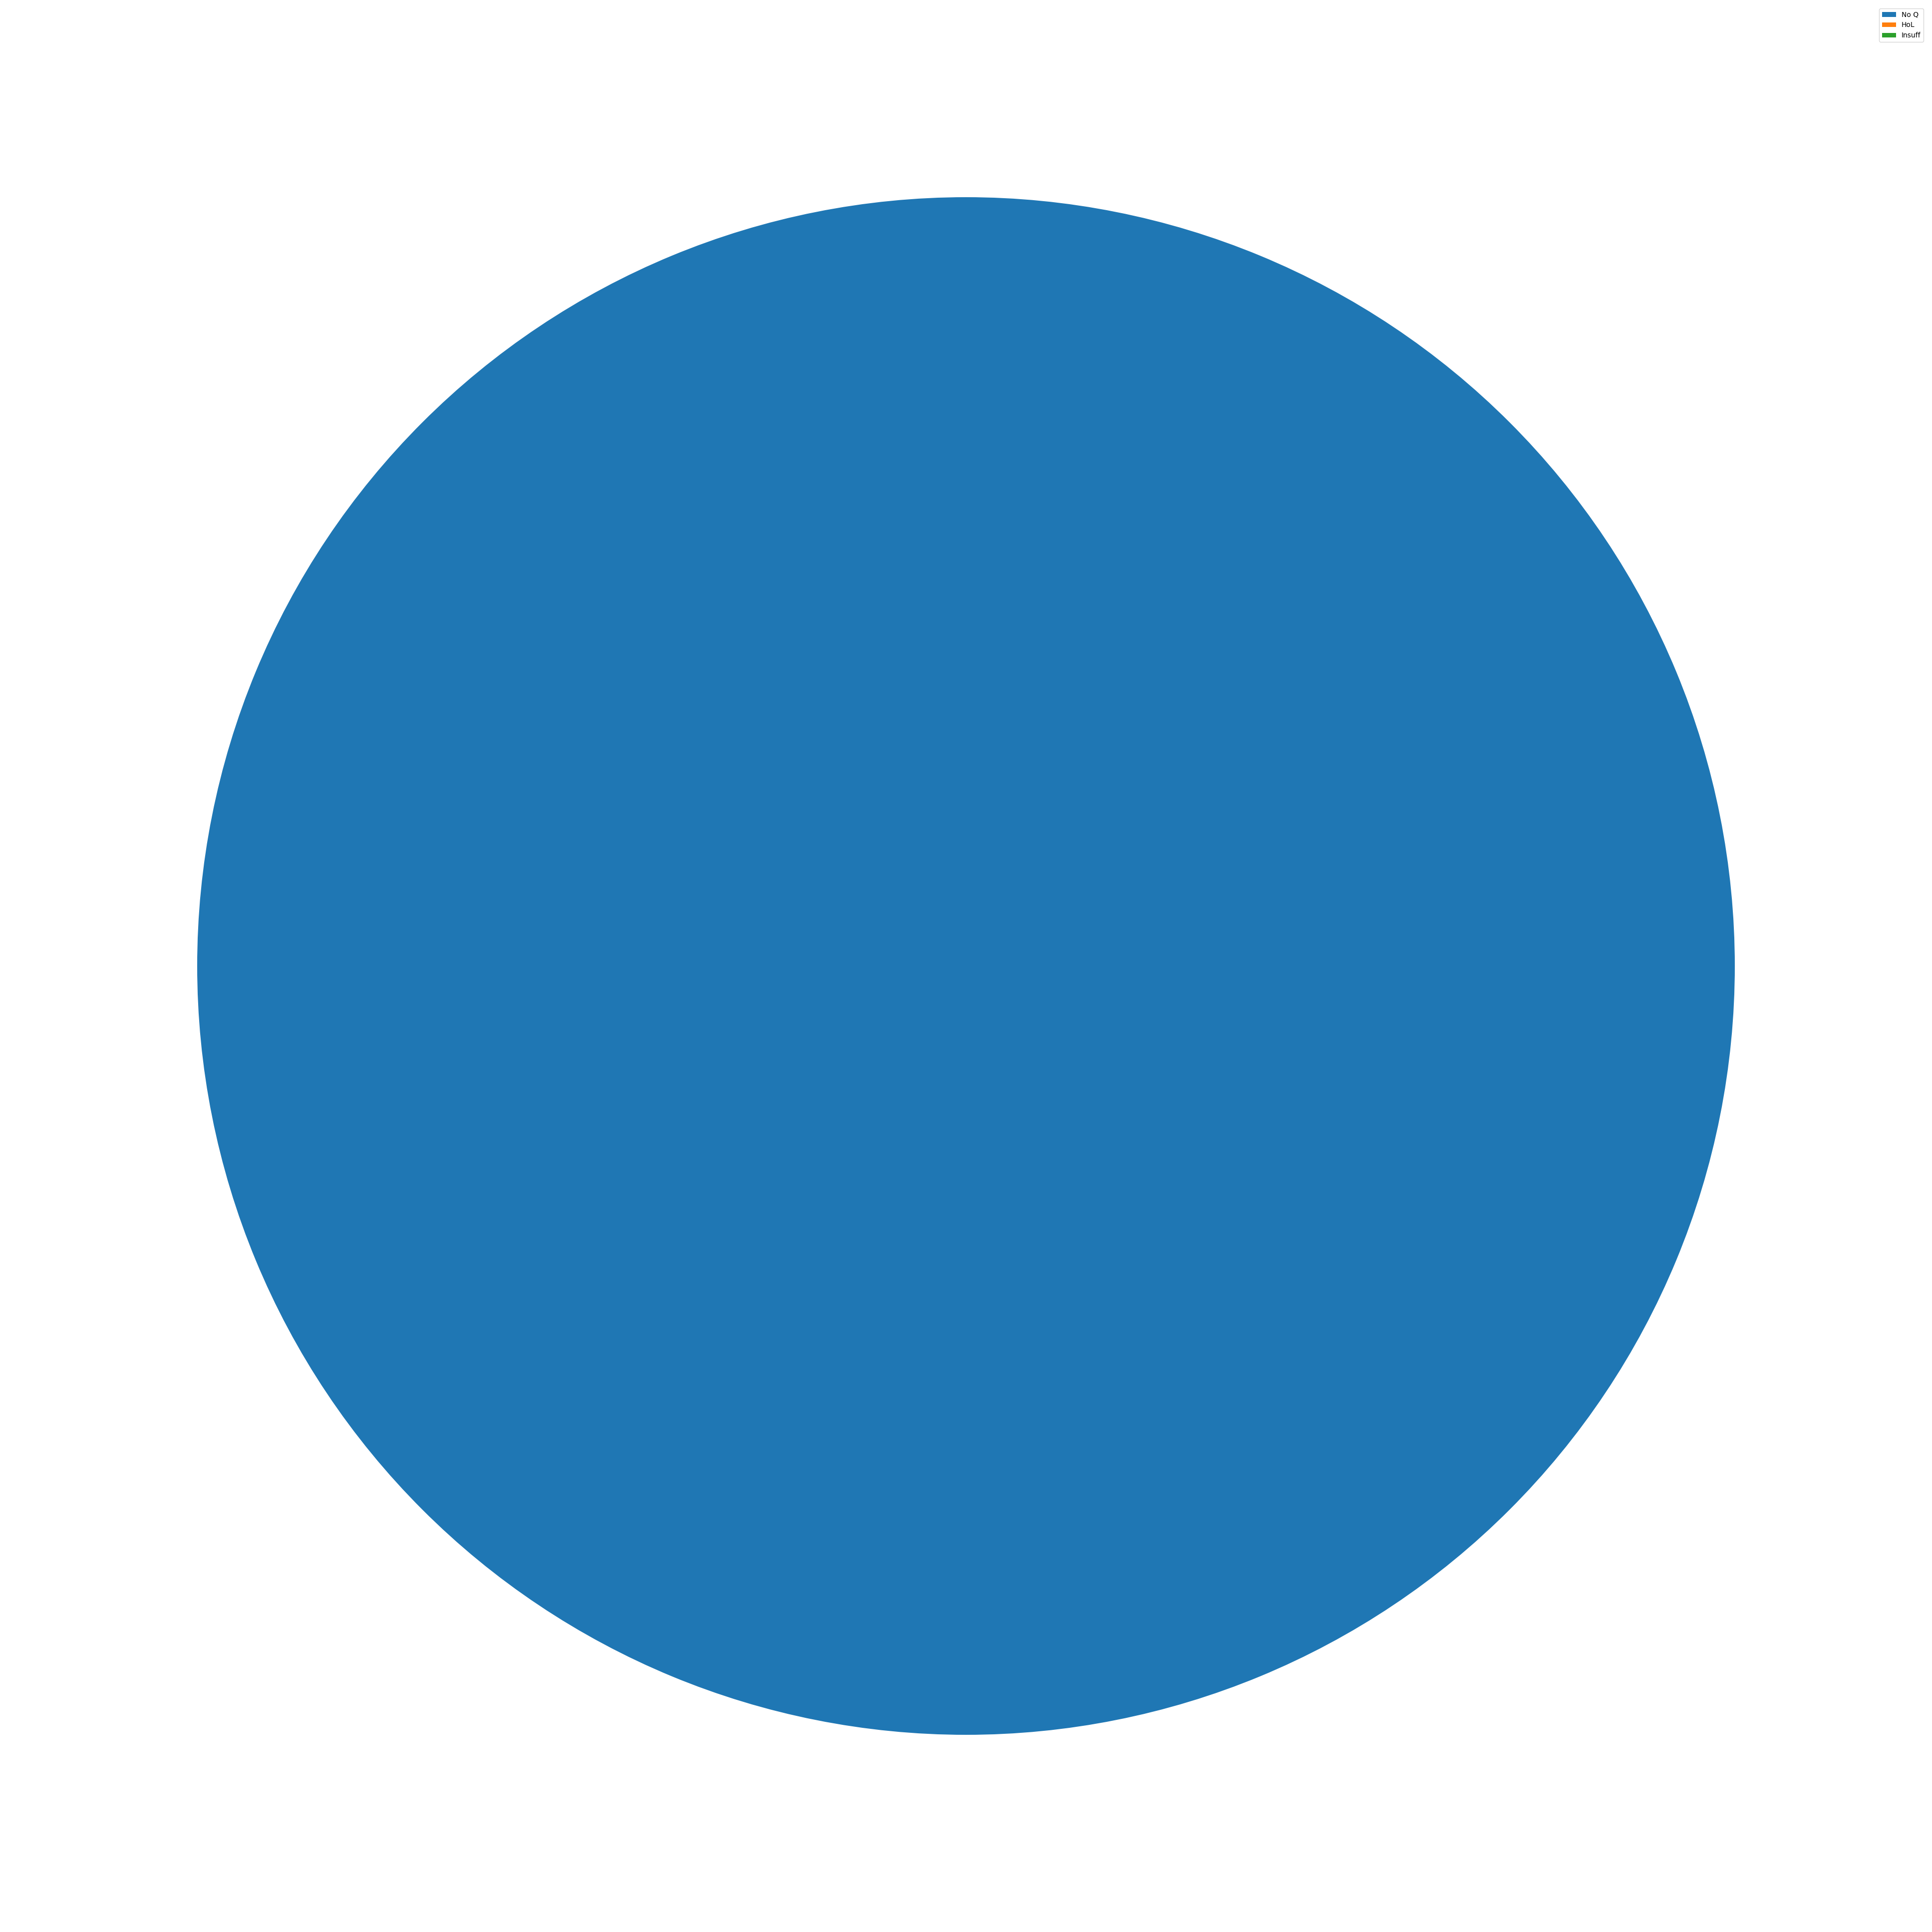

Total Cloud Cost: 263478.8763888891
Total Wasted Space: 36150.084484990286
No Q: 30212.0377006513
HoL: 15259.463412000856
Insuff: 760.4531360406233


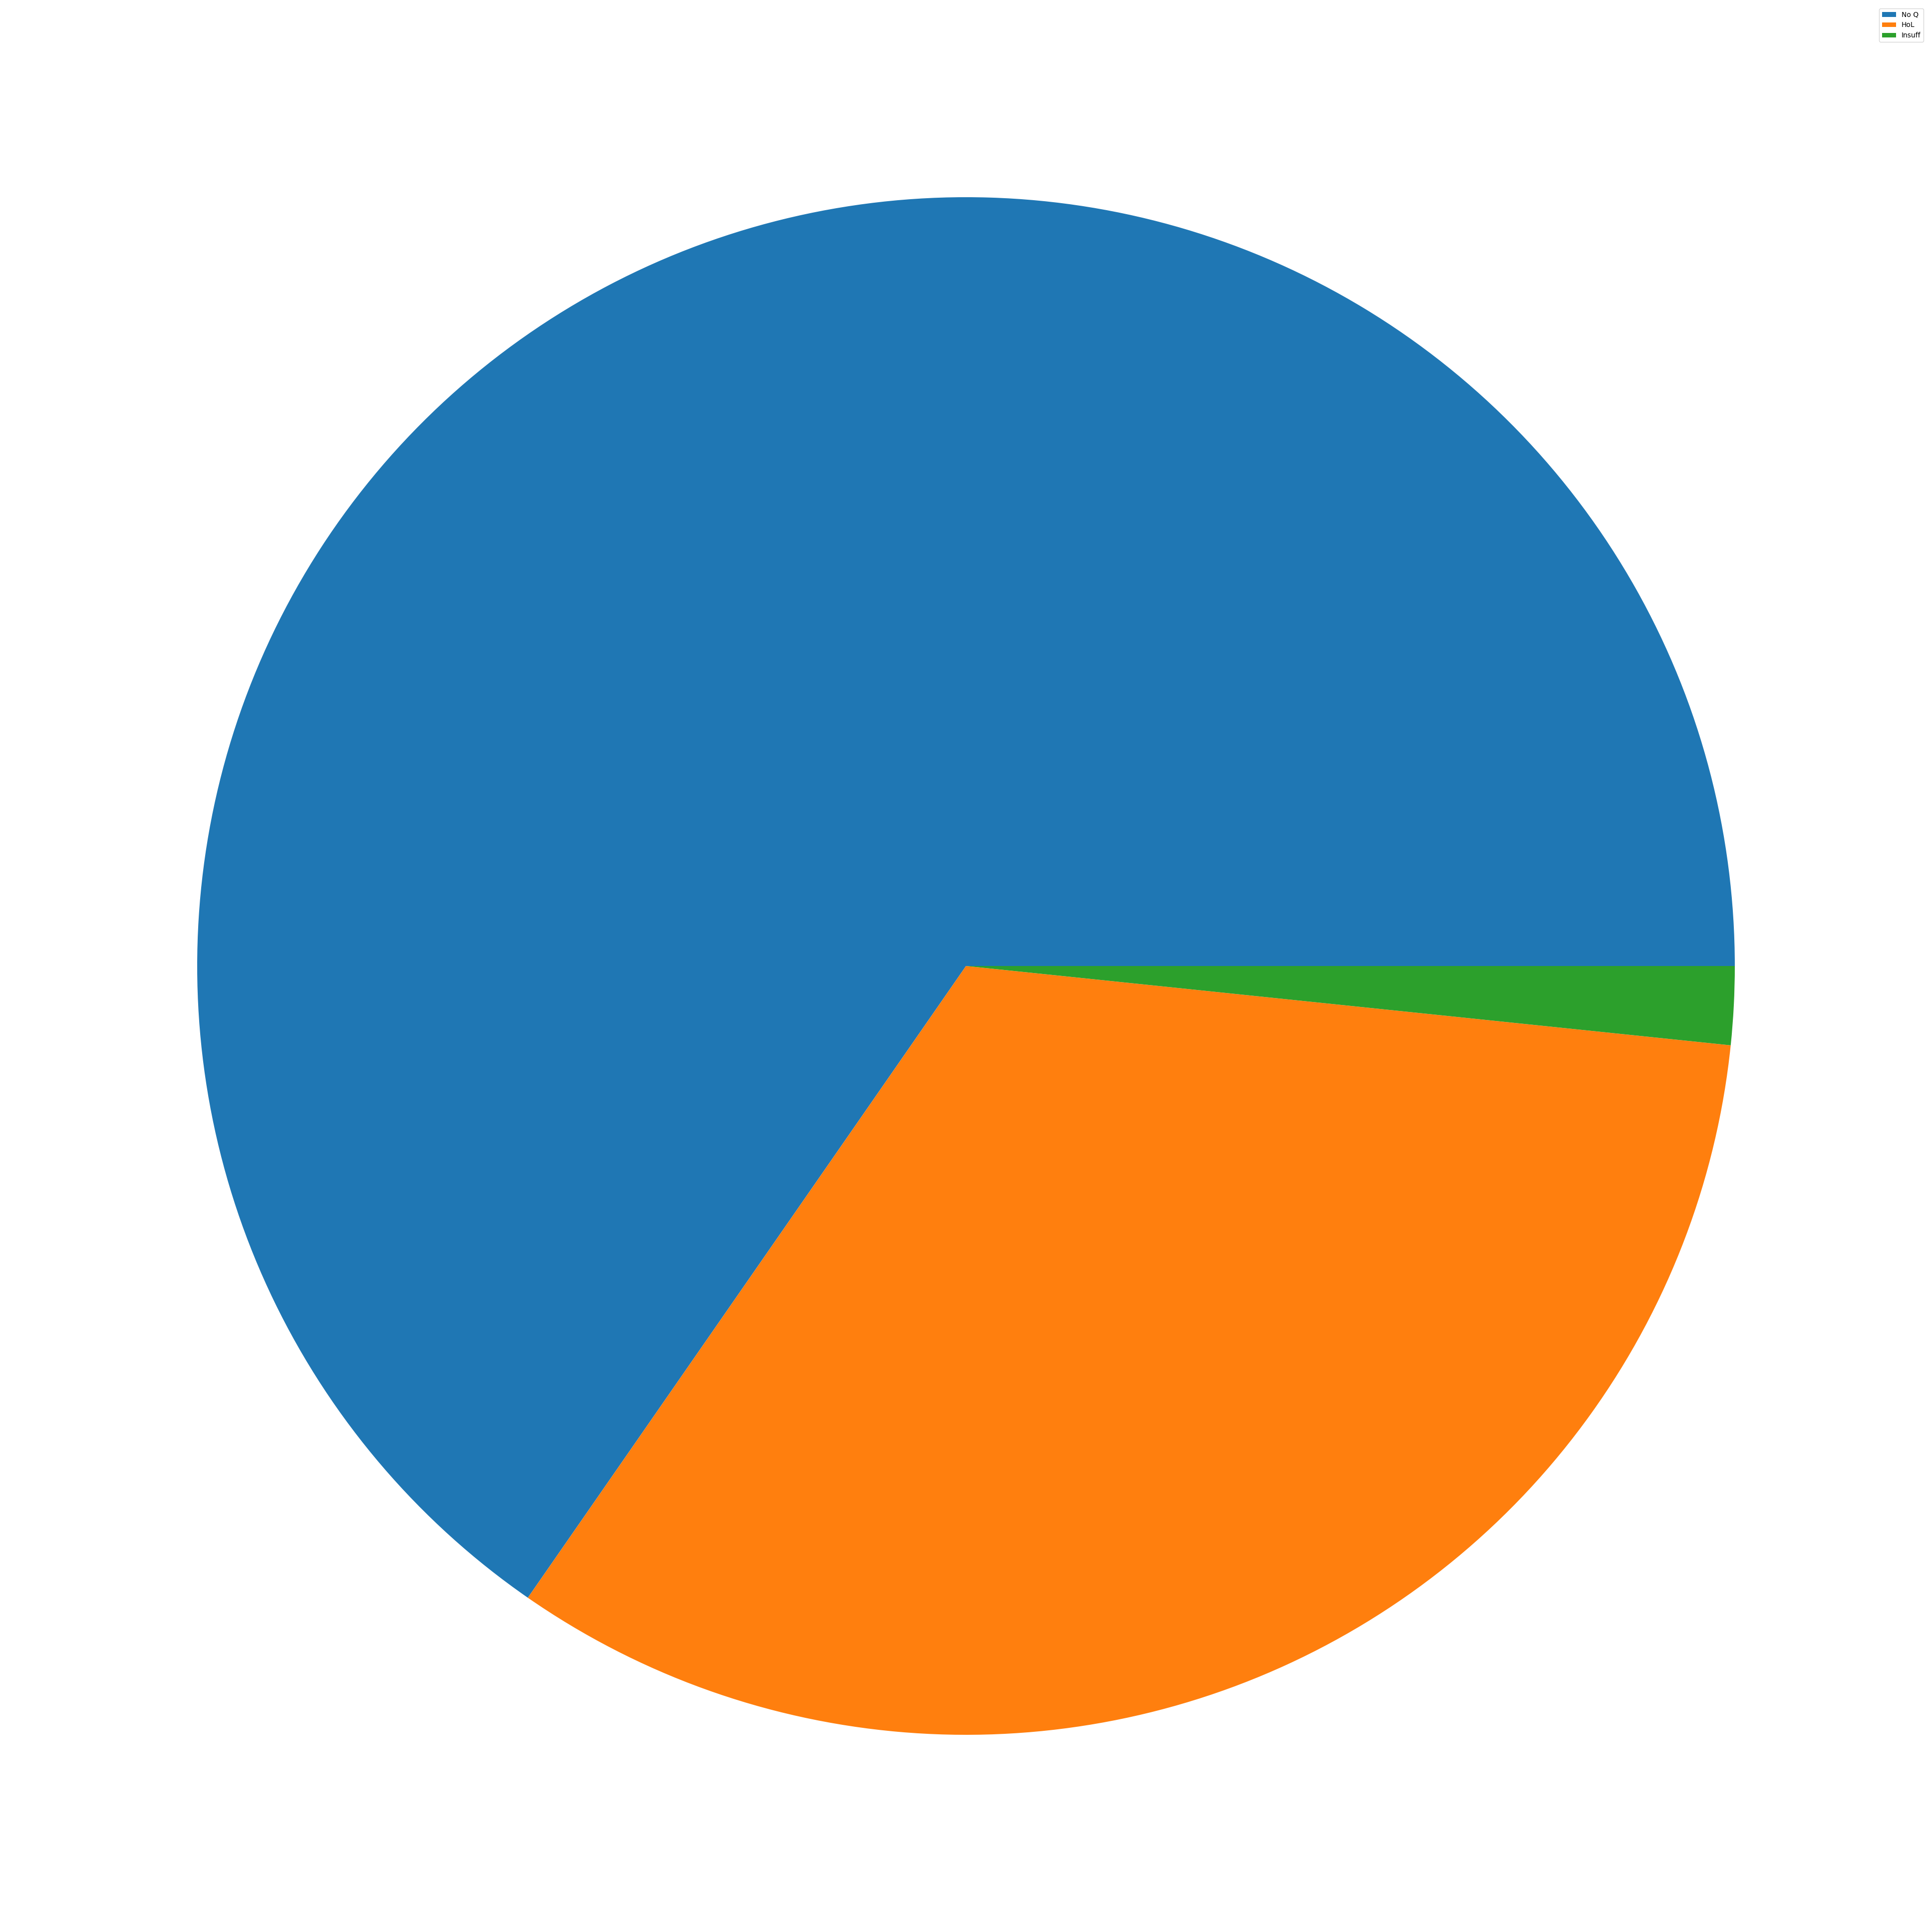

Total Cloud Cost: 282378.8827777778
Total Wasted Space: 46231.95424869278
No Q: 19765.43147979898
HoL: 37381.730447059264
Insuff: 632.1619085393805


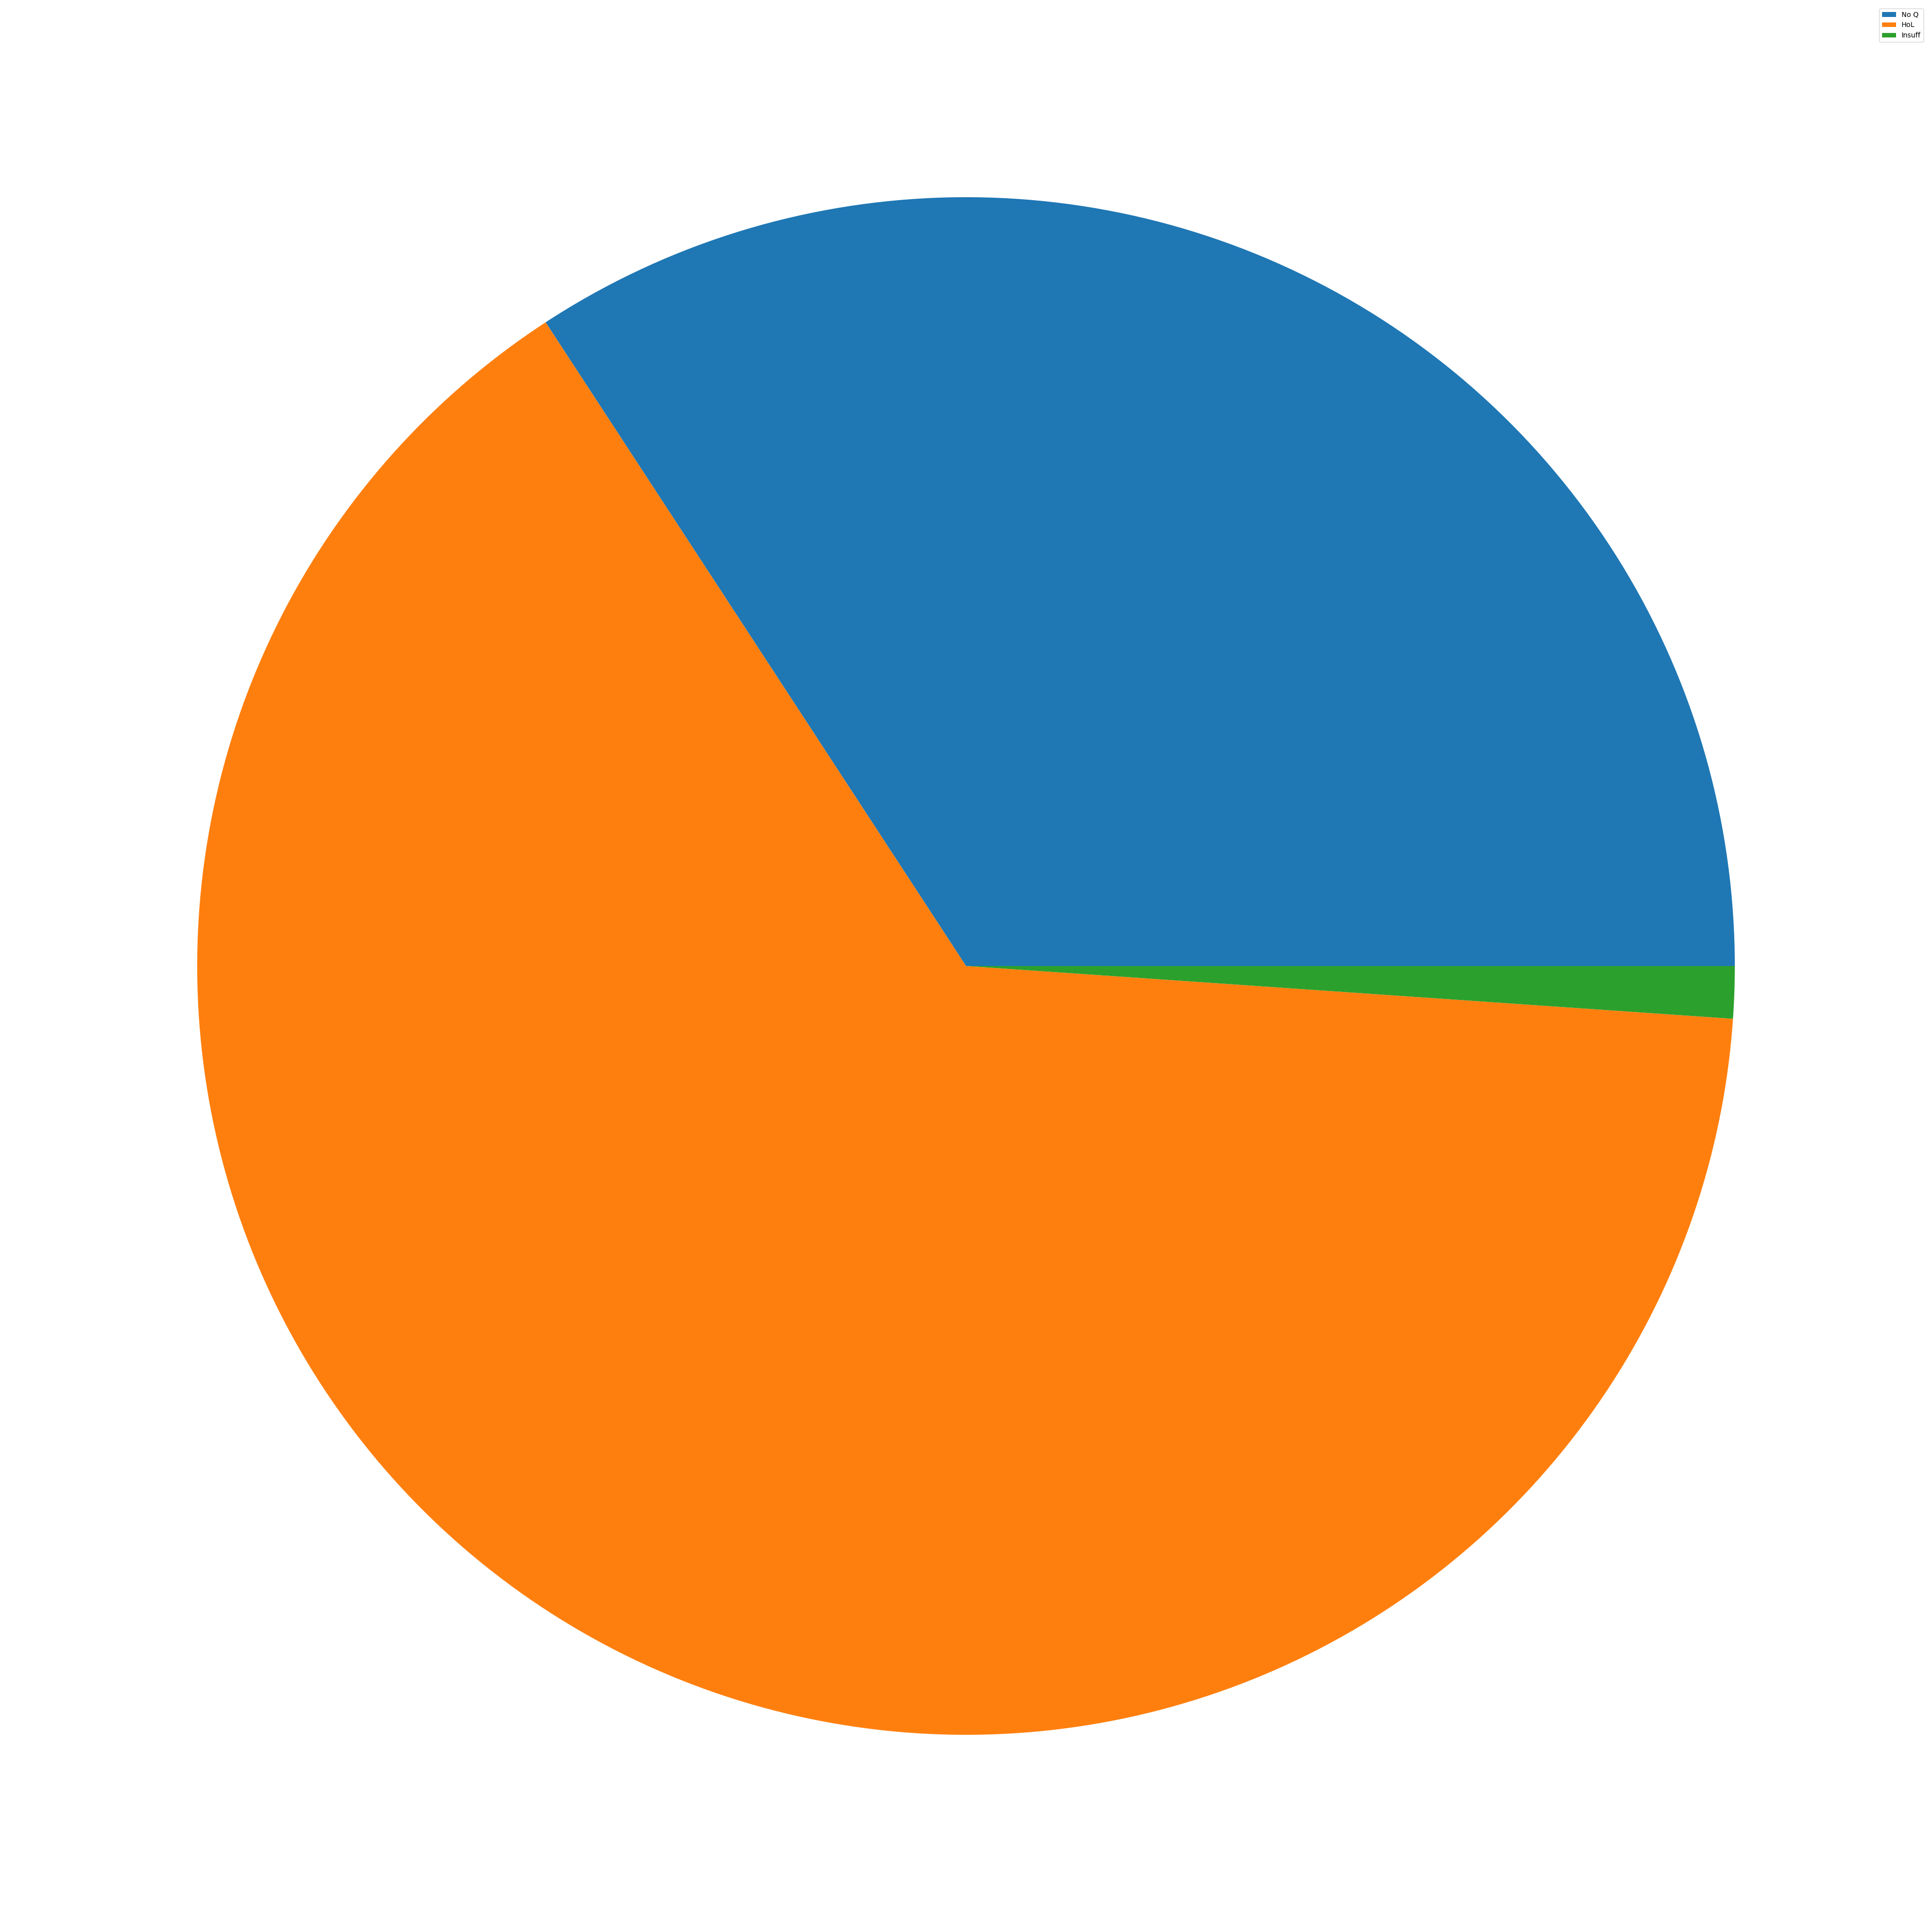

Total Cloud Cost: 293697.64527777745
Total Wasted Space: 57779.32383539763
No Q: 5826.472058682737
HoL: 64261.930739417716
Insuff: 192.49873847365757


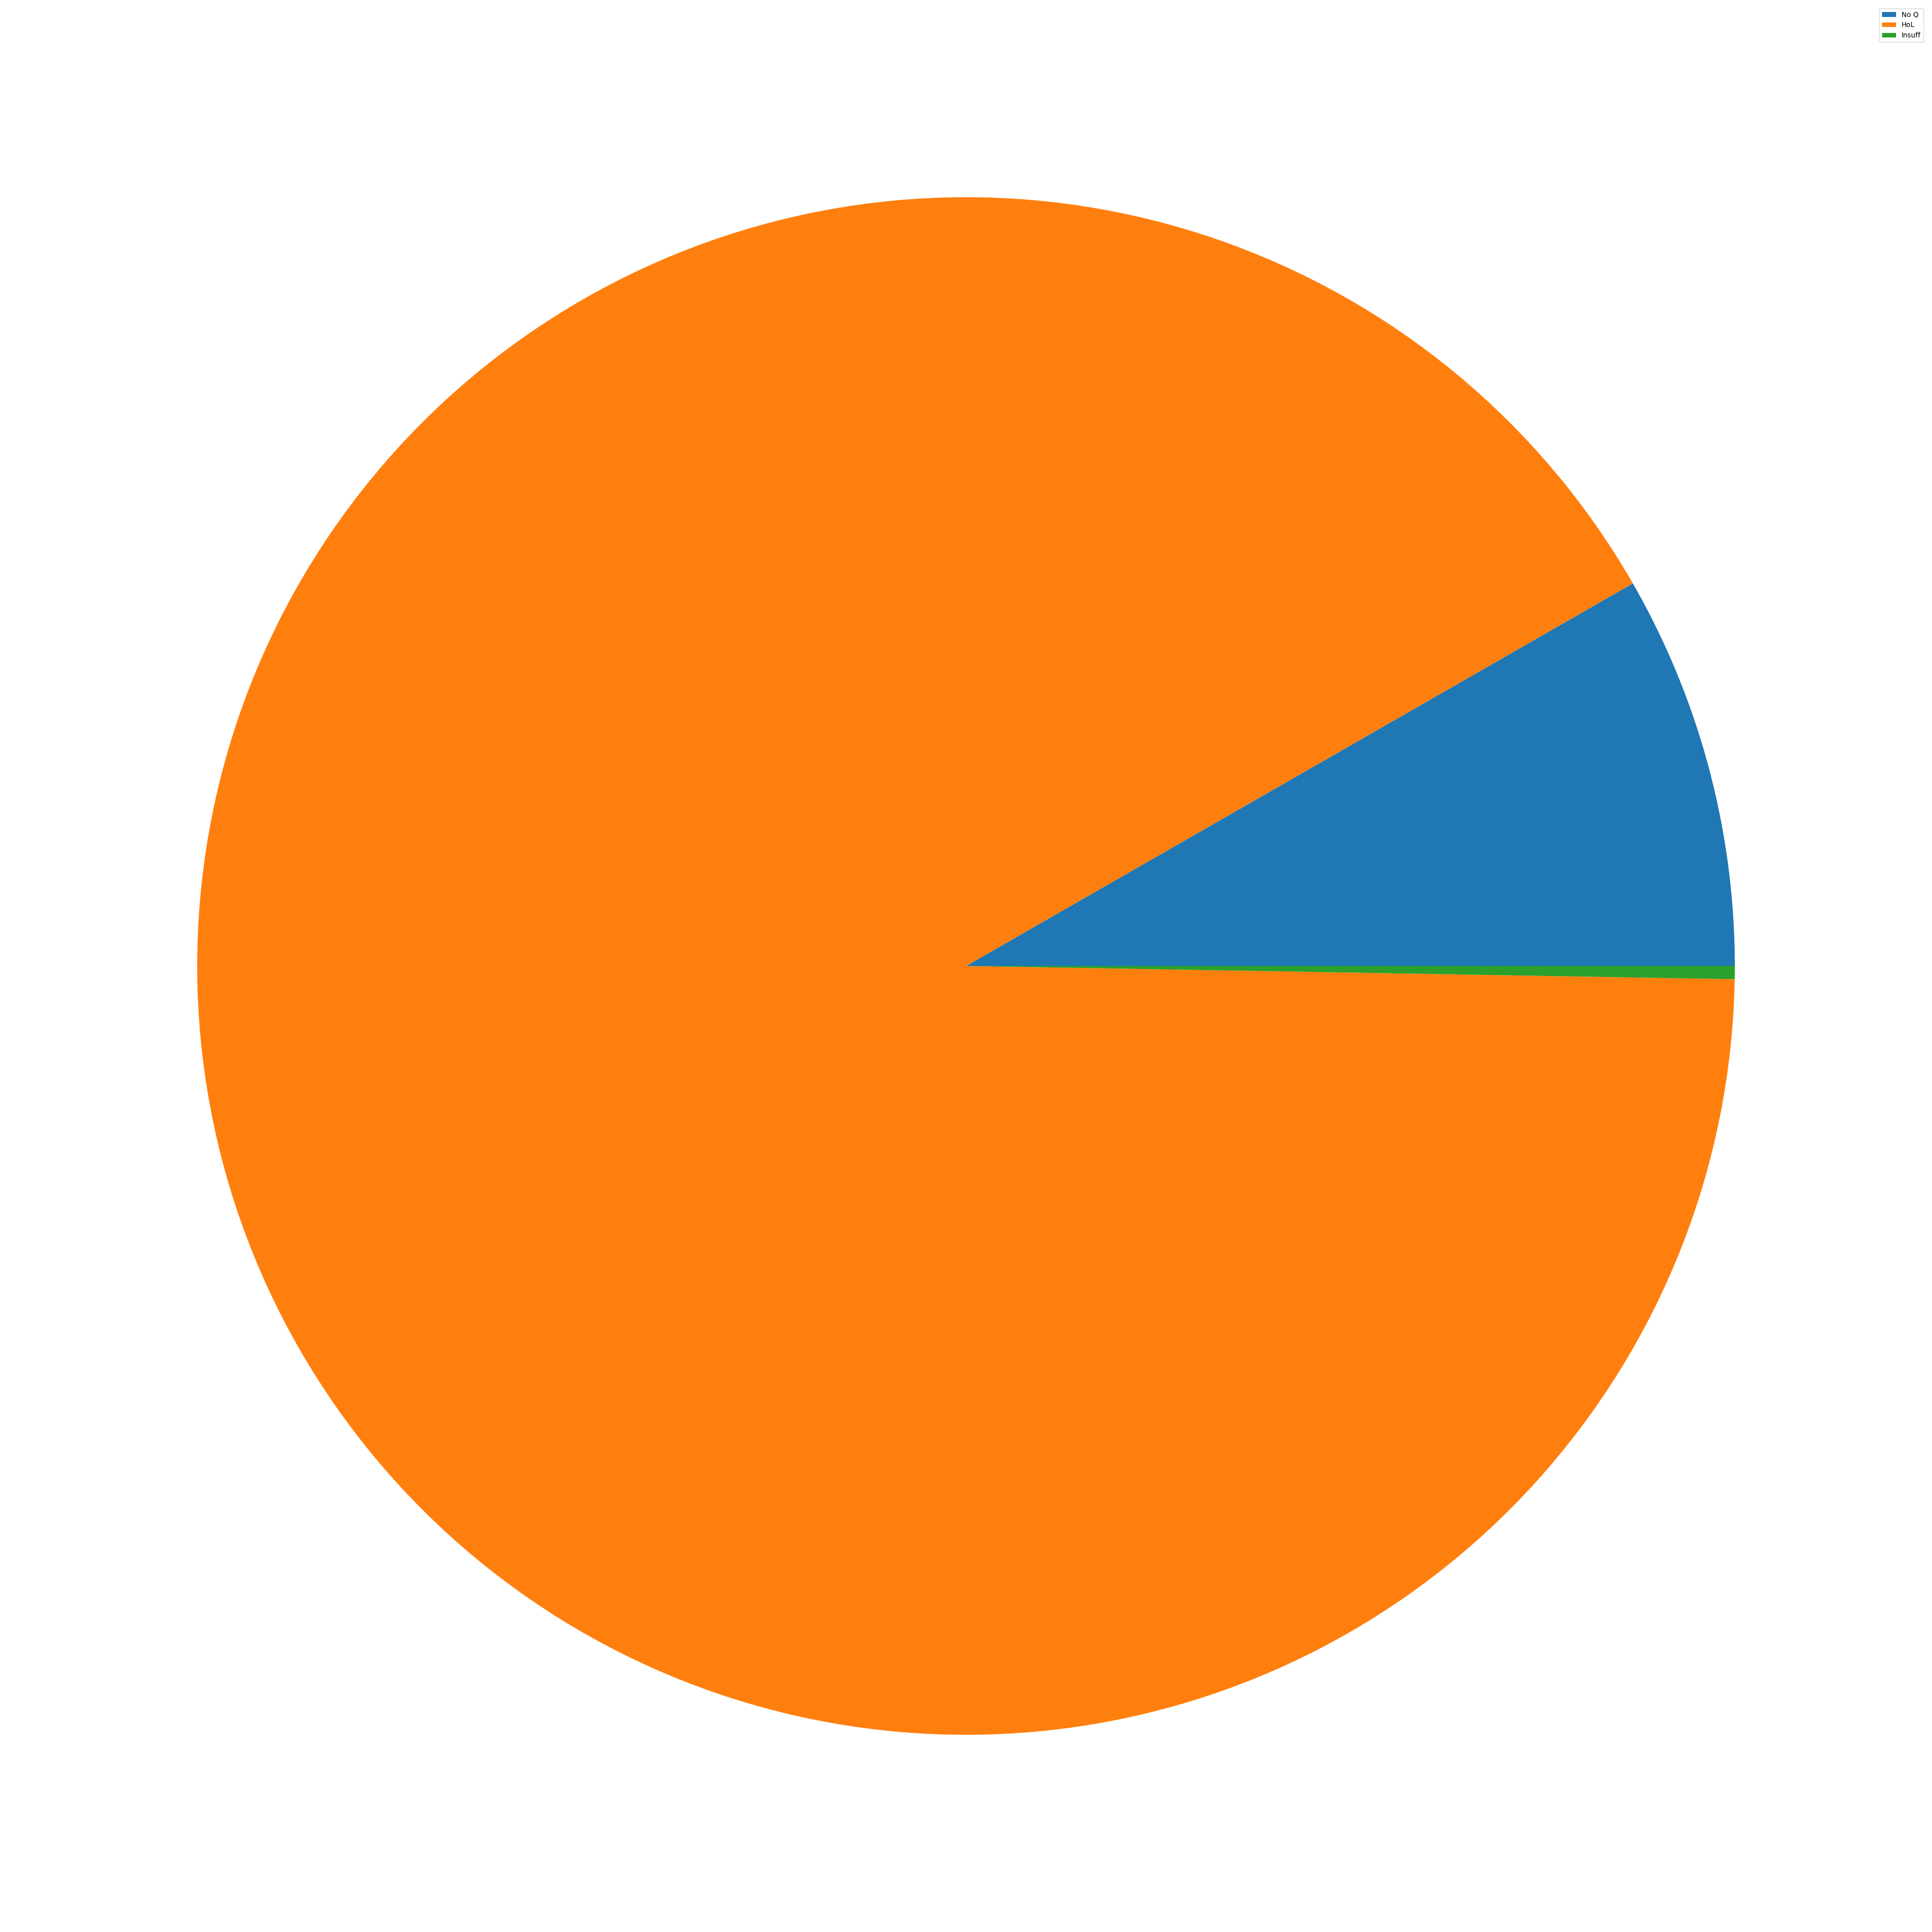

Total Cloud Cost: 309013.0588888886
Total Wasted Space: 70280.9015365741


In [6]:

# For Section 3.3
# python run_simulator_sweep.py \
# --sched_alg fifo \
# --dataset philly_gen \
# --arrival 30 32 52 \
# --total_jobs 200000 \
# --waiting_policy zero-1 constant-1 constant-2 constant-4 constant-8 \
# --seed 1002 \
# --log /home/gcpuser/starburst_logs/motivation/snapshot.log \
# --snapshot 1

# 30 32 52
results_dict = {}
for arrival in [30, 32, 52]:
    results_dict[arrival] = {}
    for wait_time in [0,1,2,4]:
        if wait_time == 0:
            filter_df = snapshot_df.loc[(snapshot_df['waiting_policy'] == 'zero') \
                                        & (snapshot_df['arrival_rate'] == arrival)]
        else:
            filter_df = snapshot_df.loc[(snapshot_df['waiting_policy'] == 'constant') \
                                        & (snapshot_df['arrival_rate'] == arrival) \
                                        & (snapshot_df['waiting_factor'] == wait_time)
                                       ]
        assert len(filter_df) == 1
        #print(filter_df)
        results_dict[arrival][wait_time] = plot_empty_space(filter_df.iloc[0], plot=False)



In [15]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=2.25)


def plot_empty_cost_bar(dict_temp, file_path='figures/motivation/high_load.pdf'):
    dict_temp_1 = copy.deepcopy(dict_temp)
    x = [0,1,2,4]
    
    plt.rcParams.update({'font.size': 15})
    fig, ax1 = plt.subplots(figsize=(10, 3))
    ax2 = ax1.twinx()
    
    ax1.grid(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_color('#DDDDDD')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_color('#DDDDDD')
    ax1.tick_params(bottom=False, left=False)
    ax1.set_axisbelow(True)
    ax1.yaxis.grid(False, color='#EEEEEE')
    ax1.xaxis.grid(False)
    ax2.tick_params(bottom=False, left=False)
    ax2.set_axisbelow(True)
    ax2.xaxis.grid(False)

    labels = ['No Q', 'HoL', 'Insuff']
    # plot the bars
    bar_width = 0.3

    # plot the bars for each label separately
    # Normalize
    temp = []
    for i, label in enumerate(labels):
        temp.extend([dict_temp[key][label] for key in x])
    max_space = max(temp)
    patterns = [ "//" , "\\\\" , "xx", "|"]
    for i, label in enumerate(labels):
        if max_space == 0.0:
            values = np.array([dict_temp[key][label] for key in x])
        else:
            values = np.array([dict_temp[key][label] for key in x])/max_space
        offset = i * bar_width
        if label == 'No Q':
            label = 'Idle'
        ax1.bar(np.arange(len(x)) + offset, values, bar_width, alpha=1.0, label=label, hatch=patterns[i])

    cloud_cost = []
    for idx in x:
        cloud_cost.append(dict_temp[idx]['cloud_cost'])
    cloud_cost = np.array(cloud_cost)
    # Normalize
    if np.max(cloud_cost)!=0:
        cloud_cost = cloud_cost/np.max(cloud_cost)
    
    # add title and axis labels
    ax1.set_xlabel('Waiting time (C)')
    ax1.set_ylabel('Empty Space')
    ax1.set_xticks(np.arange(len(x)) + bar_width, labels=x)
    # add legend
    #ax1.legend(loc='upper left')    
        
#     fig.legend([lines[2], lines[0], lines[1]], [labels[2], labels[0], labels[1]], ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    
    ax2.plot(np.arange(len(x)), cloud_cost, color='black', marker='o', label='Cloud Costs')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    print(lines2, labels2)
    fig.legend(lines1 + lines2, labels1 + labels2, ncol=1, loc='upper right', bbox_to_anchor=(1.2, 0.82))

    # add second y-axis label
    ax2.set_ylabel('Cloud Costs')
    # add legend for second y-axis
    #ax2.legend(loc='upper right')
    ax2.tick_params(labelright='off')  
    plt.tight_layout()
    plt.savefig(file_path, bbox_inches="tight")
    # show the plot
    plt.show()

In [25]:
print(results_dict)

{30: {0: {'No Q': 97302.28887981187, 'HoL': 0, 'Insuff': 0, 'cloud_cost': 9807.191111111111}, 1: {'No Q': 95778.52333776873, 'HoL': 437.5553793424549, 'Insuff': 14.694919670816034, 'cloud_cost': 9211.662777777781}, 2: {'No Q': 92447.86289067591, 'HoL': 884.7368776948501, 'Insuff': 86.98909987400702, 'cloud_cost': 6186.51}, 4: {'No Q': 89200.86983799074, 'HoL': 4240.600684078361, 'Insuff': 142.809663251433, 'cloud_cost': 6169.588055555557}}, 32: {0: {'No Q': 78593.46151883501, 'HoL': 0, 'Insuff': 0, 'cloud_cost': 27035.57861111112}, 1: {'No Q': 76238.52303799486, 'HoL': 689.0241156664588, 'Insuff': 100.72068887714784, 'cloud_cost': 26093.775555555567}, 2: {'No Q': 73741.00151162673, 'HoL': 2419.9496550632957, 'Insuff': 223.92193401908912, 'cloud_cost': 18181.541111111113}, 4: {'No Q': 66063.0132625719, 'HoL': 7272.272636444114, 'Insuff': 525.8624276077059, 'cloud_cost': 16722.303611111114}}, 52: {0: {'No Q': 36150.084484990286, 'HoL': 0, 'Insuff': 0, 'cloud_cost': 263478.8763888891}, 1:

/tmp/ipykernel_8975/4197380186.py:32: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax1.yaxis.grid(False, color='#EEEEEE')


[<matplotlib.lines.Line2D object at 0x7f8eefcae460>] ['Cloud Costs']


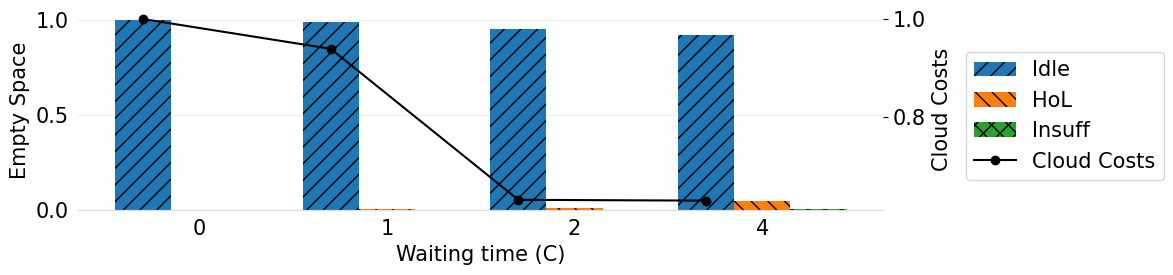

In [16]:
plot_empty_cost_bar(results_dict[30])

/tmp/ipykernel_8975/4197380186.py:32: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax1.yaxis.grid(False, color='#EEEEEE')


[<matplotlib.lines.Line2D object at 0x7f8efc0fa730>] ['Cloud Costs']


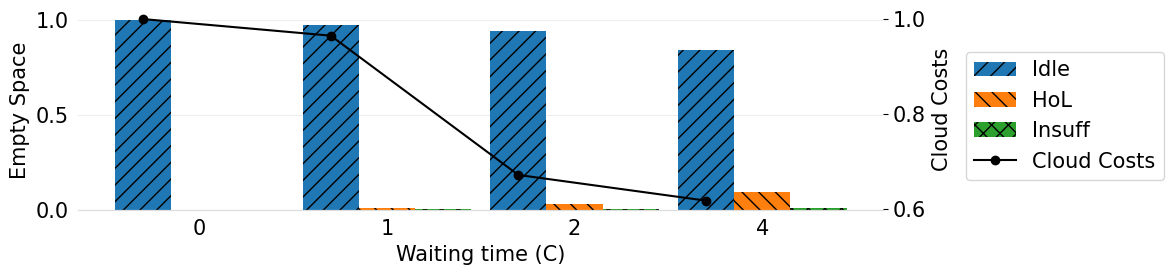

In [17]:
plot_empty_cost_bar(results_dict[32], file_path='figures/motivation/high_load.pdf')

/tmp/ipykernel_8975/4197380186.py:32: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax1.yaxis.grid(False, color='#EEEEEE')


[<matplotlib.lines.Line2D object at 0x7f8ee5bdca30>] ['Cloud Costs']


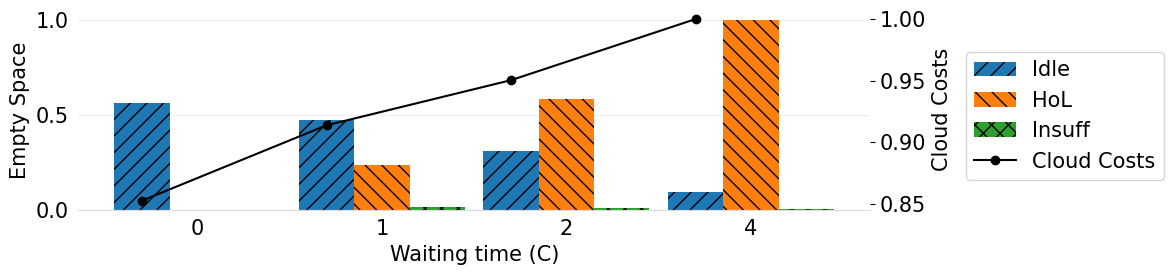

In [18]:
plot_empty_cost_bar(results_dict[52], file_path='figures/motivation/over_load.pdf')

In [55]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=2.25)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'frag_ratio': 'Frag. (%)',
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(7*len(y_axis), 7*3/8))
    if not isinstance(axs, list):
        axs = [axs]
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    def fragmentation_fraction(row):
        system_utilization_norm = min(1, row['system_utilization_y'])
        return 100*(system_utilization_norm - row['cluster_utilization_y'])/(1- row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!= 'frag_ratio' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        for ax_idx, ax in enumerate(axs):
            grp.plot(x = 'system_utilization_y', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
#     fig.legend(lines, labels, ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/motivation/fragmentation.pdf', bbox_inches='tight')
    plt.show()  

In [26]:

sim_df = utils.load_logs_as_dataframe('/home/gcpuser/sim_logs/philly/vary_cv_1337.log')

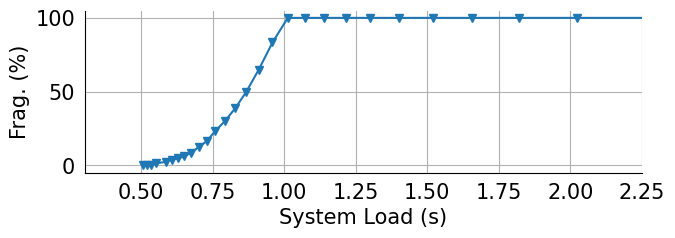

In [56]:
simulator_plotting_fn(sim_df, x_axis='cluster_size',  \
                      df_filter = {'waiting_policy': 'zero', 'loop': 1}, \
                      y_axis=['frag_ratio'], \
                      baseline_filter={'waiting_policy': 'zero','loop': 1},
                      groupby_values=['waiting_policy', 'waiting_factor', 'loop'],
                      normalize_x_axis=True)

In [21]:
constant_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/motivation/constant_ablate.log')

In [52]:

my_plotting_df = constant_df[(constant_df['waiting_policy']=='constant') & (constant_df['waiting_factor']==1) & (constant_df['arrival_rate']==92)]

wait_times = my_plotting_df['deadline'] - my_plotting_df['runtime'] - my_plotting_df['arrival']
num_gpus = my_plotting_df['num_gpus']

/tmp/ipykernel_8975/1001660103.py:36: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax1.yaxis.grid(False, color='#EEEEEE')


{'s=0.6': {1: 0.00033872269746952003, 4: 0.0001321599493121722, 8: 0.0003607684068829613, 2: 0.00035211691886803686, 32: 0.005089058524173028, 16: 0.0004437101380460195, 64: 0.030303030303030304}, 's=1': {1: 0.10875090899952246, 4: 0.12563574560749363, 8: 0.25791778708139196, 2: 0.110378327348341, 32: 0.6093884074425868, 16: 0.423861879894779, 64: 0.7902012387073476}, 's=2': {1: 0.554983087554498, 4: 0.6028160529885348, 8: 0.9173019931309325, 2: 0.5592211892322605, 32: 0.9949109414758305, 16: 0.9848952562407471, 64: 1.0}}


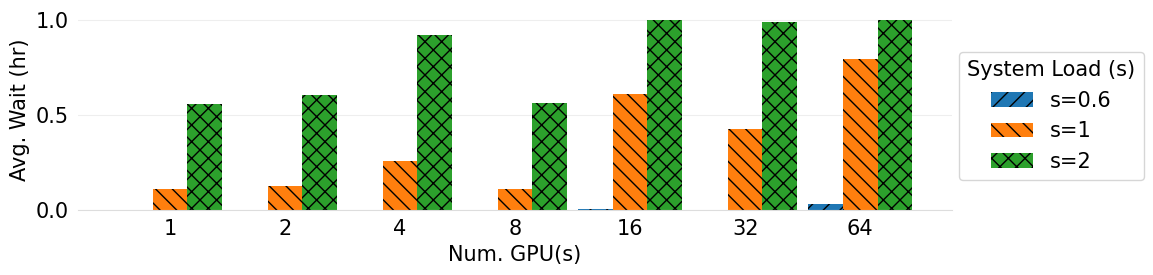

In [23]:
import copy

def plot_wait_versus_size(df):
    filter_df = constant_df[(constant_df['waiting_policy']=='constant') & (constant_df['waiting_factor']==1)]
    label_to_arrival = {
        's=0.6': 24,
        's=1': 40,
        's=2': 80,
    }
    waiting_dict = {}
    x = [1,2,4,8,16,32,64]
    for label, arr in label_to_arrival.items():
        waiting_dict[label] = {}
        full_filter_df = filter_df[filter_df['arrival_rate']==arr]
        wait_times = np.array(full_filter_df['start'] - full_filter_df['arrival'])[0]
        num_gpus = np.array(full_filter_df['num_gpus'])[0]
        for w, n in zip(wait_times, num_gpus):
            if n in x and n not in waiting_dict[label]:
                waiting_dict[label][n] = []
            if n in x:
                waiting_dict[label][n].append(w)
        
        for _x in x:
            waiting_dict[label][_x] = np.mean(waiting_dict[label][_x])
    
    plt.rcParams.update({'font.size': 15})
    fig, ax1 = plt.subplots(figsize=(10, 3))
    
    ax1.grid(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_color('#DDDDDD')
    ax1.tick_params(bottom=False, left=False)
    ax1.set_axisbelow(True)
    ax1.yaxis.grid(False, color='#EEEEEE')
    ax1.xaxis.grid(False)

    # plot the bars
    bar_width = 0.3
    
    waiting_dict = copy.deepcopy(waiting_dict)
#     colors = {
#         'Low': 'tab:blue',
#         'High': 'tab:green',
#         'Overloaded': 'tab:red'
#     }
    patterns = [ "//" , "\\\\" , "xx", "|"]    
    for i, label in enumerate(label_to_arrival.keys()):
        offset = i * bar_width
        ax1.bar(np.arange(len(x)) + offset, list(waiting_dict[label].values()), bar_width, \
                alpha=1.0, label=label, hatch=patterns[i])

    print(waiting_dict)
    
    # add title and axis labels
    ax1.set_xlabel('Num. GPU(s)')
    ax1.set_ylabel('Avg. Wait (hr)')
    ax1.set_xticks(np.arange(len(x)) + bar_width, labels=x)
    # add legend
#     ax1.legend(loc='upper left')
    lines, labels = ax1.get_legend_handles_labels()
#     fig.legend(lines, labels, ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    fig.legend(lines, labels, ncol=1, loc='upper right', bbox_to_anchor=(1.18, 0.82), title='System Load (s)')
    plt.tight_layout()
    plt.savefig('figures/motivation/hol.pdf', bbox_inches="tight")
    # show the plot
    plt.show()
plot_wait_versus_size(constant_df)

In [112]:
# Compute Cost Ratio
from skyburst import job_gen
jobs_proc = job_gen.load_processed_jobs({'dataset': 'philly'})

In [113]:
gpu_dict = {}
count_dict = {}
total_cost = 0
for j in jobs_proc:
    if j.num_gpus not in gpu_dict:
        gpu_dict[j.num_gpus] = 0
    if j.num_gpus not in count_dict:
        count_dict[j.num_gpus] = 0
    gpu_dict[j.num_gpus] += 2.5*j.cost
    count_dict[j.num_gpus]+=1
    total_cost += 2.5*j.cost

print(gpu_dict)

print(count_dict)
for k in gpu_dict.keys():
    gpu_dict[k] /= total_cost
    count_dict[k] /= len(jobs_proc)
    
value_list = [0, 1, 8, 32, 1e9]
for idx in range(len(value_list)-1):
    total_cost = 0
    total_count = 0
    for k in gpu_dict.keys():
        if k >= value_list[idx] and k < value_list[idx+1]:
            total_cost+= gpu_dict[k]
            total_count += count_dict[k]
    print(f'{value_list[idx]}-{value_list[idx+1]} Cost: {total_cost}')
    print(f'{value_list[idx]}-{value_list[idx+1]} Count: {total_count}')
            

{8: 1429420.827777779, 1: 484333.1083333317, 16: 367603.28888888867, 4: 451486.47499999945, 2: 85357.84305555542, 32: 54888.33333333336, 0: 0.0, 12: 82.16666666666666, 24: 13439.2, 64: 1588.8888888888887, 128: 1796.8000000000002}
{8: 1740, 1: 77294, 16: 227, 4: 1950, 2: 1839, 32: 73, 0: 4, 12: 7, 24: 10, 64: 6, 128: 4}
0-1 Cost: 0.0
0-1 Count: 4.81035187723982e-05
1-8 Cost: 0.35334896556510315
1-8 Count: 0.9750944031555908
8-32 Cost: 0.6264869914983521
8-32 Count: 0.023859345311109503
32-1000000000.0 Cost: 0.020164042936548953
32-1000000000.0 Count: 0.0009981480145272626


In [3]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=2.25)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    ('zero', 1, 0, 0): 'No-Wait',
    ('linear_cost', 0.076, 0, 0): 'Compute-Wait',
    ('linear_cost', 0.076, 0, 1): 'Compute-Wait + Loop',
    ('linear_cost', 0.076, 1, 0): 'Compute-Wait + Backfill',
    
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 1.1*(baseline_cost - cost)
    
    def fragmentation_fraction(row):
        system_utilization_norm = min(1, row['norm_system_utilization'])
        return (-system_utilization_norm + row['cluster_utilization_y'])
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    old_groupby_values = groupby_values
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if label == 'No-Wait':
                if ax_idx < 1:
                    continue
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/loop_short.pdf', bbox_inches='tight')
    plt.show()  

In [4]:

sim_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/motivation/loop.log')

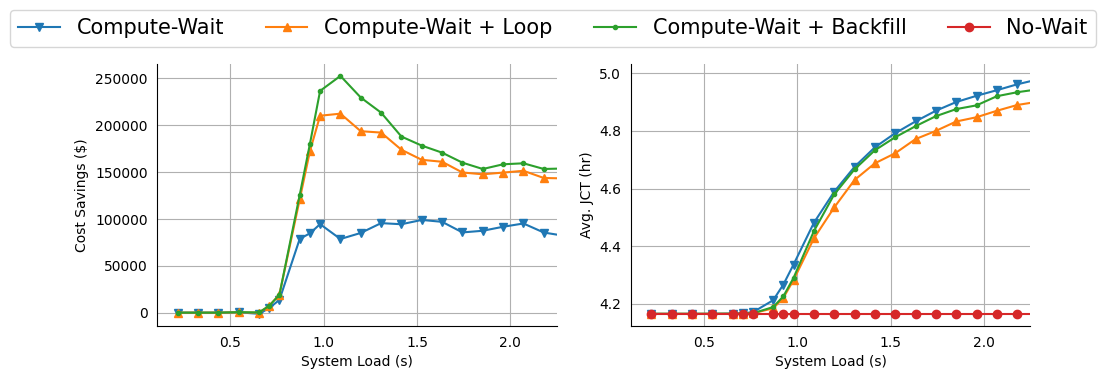

In [5]:
# simulator_plotting_fn(sim_df, x_axis='arrival_rate',  \
#                       y_axis=['cost_mult','cost_diff','avg_jct','cluster_utilization'], \
#                       baseline_filter={'waiting_policy': 'zero','predict_wait': 0},
#                       groupby_values=['waiting_policy', 'waiting_factor', 'backfill', 'loop'],
#                       normalize_x_axis=True)

simulator_plotting_fn(sim_df, x_axis='arrival_rate',  \
                      y_axis=['cost_diff','avg_jct',], \
                      baseline_filter={'waiting_policy': 'zero','predict_wait': 0},
                      groupby_values=['waiting_policy', 'waiting_factor', 'backfill', 'loop'],
                      normalize_x_axis=True)